In [1]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from itertools import izip
import os

from IPython.core.display import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import pybedtools
from scipy.stats import hypergeom
import seaborn as sns
import scipy.stats
from matplotlib_venn import venn3

from clipper.src import CLIP_analysis
from gscripts.general import dataviz
from gscripts import GO
from gscripts.general import region_helpers

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/figures"

In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rbp_name_dict = {"taf15": "TAF15",
                 "tls": "FUS/TLS",
                 "tdp43": "TDP43"}
cell_type_dict = {"whole brain": "Whole Brain",
                  "spinal cord": "Spinal Cord",
                  "striatum": "Striatum"}

color_map = {"fus": '#43A247',
              'taf15': '#DB1D3D',
              'tdp43': '#712878',
              'fus_taf15': 'c',
              'taf15_tdp43': 'c'}

Get Gene ID and Name mapping
-----

In [3]:
def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]
        
def plot_go_enrichment(df, filter_value=None, max_terms=None, **kwargs):
    df = df.copy()
    new_index = []
    for index, description in izip(df.index, df['GO Term Description']):
        new_index.append(list(index[:-1]) + [description])
    df.index = pd.MultiIndex.from_tuples(new_index)

    go_matrix = df['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))
    go_matrix = go_matrix.unstack(range(len(go_matrix.index.levels) - 1))
    go_matrix = go_matrix.fillna(0)
    
    #Set cutoff on values 
    if filter_value is not None:
        go_matrix = go_matrix[go_matrix.apply(max, axis=1) > filter_value]
    
    #Set cutoff on number of go terms to show
    if max_terms is not None:
        go_matrix = go_matrix.ix[go_matrix.max(axis=1).order(ascending=False).index].ix[:max_terms]
    sns.clustermap(go_matrix, robust=True, **kwargs)
    
def get_expressed_genes(rbp, cell_type):
    name = (rbp, cell_type)
    mapping = mapper[name]
    indexer = mapping[:-1]
    analysis_group = mapping[-1]
    control_rpkms = rpkm.xs(analysis_group, level="analysis_group").ix[indexer]
    return list(gencode_to_ensembl(control_rpkms[control_rpkms > 1].dropna(axis=1).columns))

In [4]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")
name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [5]:
ensembl_to_gencode = {key.split(".")[0]: key for key in gene_id_to_name.keys()}

In [6]:
def open_splicing_matrix(fn):
    df = pd.read_table(fn, index_col=0)
    new_index = []
    for item in df.index:
        item = item.split("|")
        new_index.append(item)

    df.index = pd.MultiIndex.from_tuples(new_index, names=["gene", "splice_type", "location"])
    return df

def open_omniviewer(fn):
    #Think about adding in / flitering on q-values
    df = pd.read_table(fn).sort(columns=['event name', 'path'])
    df = df[(df.path != "sk") &  ~(df.notes.str.contains("Ncomplex"))]
    df.index = pd.MultiIndex.from_tuples(list(izip(df['event name'], df['notes'], df['event position'])), 
                                         names=["gene", "splice_type", "location"])
   
    num_sepscores = np.arange((len(df.columns) - 5) / 7)
    sepscores = np.array(num_sepscores) * 7 + 6
    qvalues = sepscores + 1
    return df.iloc[:,sepscores], df.iloc[:,qvalues]

#Load All Data from Steph's Analysis

In [7]:
index_names = ["rbp", "cell_type"]

ews_names = [["ews", "spinal cord"]]
ews_full, ews_qvalue = open_omniviewer("/nas3/shuelga/projects/ews_splicing/ews_taf15_omniviewer.txt")
ews_full = ews_full.drop("mjay_sepscore_yeo_TAF15_spcord_sepscore", axis=1)
ews_qvalue = ews_qvalue.drop("mjay_sepscore_yeo_TAF15_spcord_q-value", axis=1)

ews_full.columns = pd.MultiIndex.from_tuples(ews_names, names=index_names)
ews_qvalue.columns = pd.MultiIndex.from_tuples(ews_names, names=index_names)

taf15_names = [["taf15", "striatum"], ["taf15", "whole brain"], ["taf15", "spinal cord"]]
taf15_full, taf15_qvalue = open_omniviewer("/nas3/shuelga/projects/taf15_splicing/striatumTAF15_brainTAF15_spinalTAF15_omniviewer.txt")

taf15_full.columns = pd.MultiIndex.from_tuples(taf15_names, names=index_names)
taf15_qvalue.columns = pd.MultiIndex.from_tuples(taf15_names, names=index_names)

tia1_elav_names = [["tia1", "whole brain"], ["elav", "spinal cord"], ["tia1", "spinal cord"]]
tia1_elav_full, tia1_elav_qvalue = open_omniviewer("/nas3/gpratt/projects/kris/data/elav_something_corrected.csv")

tia1_elav_full.columns = pd.MultiIndex.from_tuples(tia1_elav_names, names=index_names)
tia1_elav_qvalue.columns = pd.MultiIndex.from_tuples(tia1_elav_names, names=index_names)

a2b1_names = [["hnrnpa2b1", "spinal cord"]]
a2b1_full, a2b1_qvalue = open_omniviewer("/nas3/shuelga/projects/a2b1_splicing/a2b1sc_omniviewer.txt")

a2b1_full.columns = pd.MultiIndex.from_tuples(a2b1_names, names=index_names)
a2b1_qvalue.columns = pd.MultiIndex.from_tuples(a2b1_names, names=index_names)

tdp43tls_names = [["tdp43", "striatum"], ["tls", "striatum"]]
tdp43tls_full, tdp43tls_qvalue = open_omniviewer("/nas3/shuelga/old_projects/TLS/jxnarray/TDP43KD_TLSKD_TLSKO.txt")

tdp43tls_full = tdp43tls_full.drop("mjay_sepscore_yeo_august_ko56_sepscore", axis=1)
tdp43tls_qvalue = tdp43tls_qvalue.drop("mjay_sepscore_yeo_august_ko56_q-value", axis=1)

tdp43tls_full.columns = pd.MultiIndex.from_tuples(tdp43tls_names, names=index_names)
tdp43tls_qvalue.columns = pd.MultiIndex.from_tuples(tdp43tls_names, names=index_names)

tia1_names = [["tia1", "striatum"]]
tia1_full, tia1_qvalue = open_omniviewer("/nas3/shuelga/projects/taf15_splicing/taf15_tia1_omniviewer.txt")
tia1_full = tia1_full.drop("mjay_sepscore_yeo_stTAF15_sepscore", axis=1)
tia1_qvalue = tia1_qvalue.drop("mjay_sepscore_yeo_stTAF15_q-value", axis=1)

tia1_full.columns = pd.MultiIndex.from_tuples(tia1_names, names=index_names)
tia1_qvalue.columns = pd.MultiIndex.from_tuples(tia1_names, names=index_names)

all_events_full = pd.concat([ews_full, taf15_full, tia1_elav_full, a2b1_full, tdp43tls_full, tia1_full], axis=1)
all_events_full = all_events_full.fillna(0.)
all_events_full = all_events_full.groupby(level=all_events_full.index.names)  
all_events_full = all_events_full.last()

all_events_qvalue = pd.concat([ews_qvalue, taf15_qvalue, tia1_elav_qvalue, a2b1_qvalue, tdp43tls_qvalue, tia1_qvalue], axis=1)
all_events_qvalue = all_events_qvalue.fillna(1.)
all_events_qvalue = all_events_qvalue.groupby(level=all_events_qvalue.index.names)  
all_events_qvalue = all_events_qvalue.last()

In [8]:
all_events_full.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/splicing_matrix_sepscores.csv")
all_events_qvalue.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/splicing_matrix_qvalue.csv")

In [9]:
ews = open_splicing_matrix("/nas3/shuelga/projects/ews_splicing/analysis/all_events_sep_matrix.txt")
ews = ews.drop("taf15", axis=1)
ews.columns = pd.MultiIndex.from_tuples([["ews", "spinal cord"]], names=["rbp", "cell_type"])

taf15 = open_splicing_matrix("/nas3/shuelga/projects/taf15_splicing/analysis_allTAF15/all_events_sep_matrix.txt")
taf15.columns = pd.MultiIndex.from_tuples(
[["taf15", "striatum"],
["taf15", "whole brain"],
["taf15", "spinal cord"]]

, names=["rbp", "cell_type"])

tia1_elav = open_splicing_matrix("/nas3/gpratt/projects/kris/analysis/all_events_sep_matrix.txt")
tia1_elav.columns = pd.MultiIndex.from_tuples(
[["tia1", "whole brain"],
["elav", "spinal cord"],
["tia1", "spinal cord"]]
, names=["rbp", "cell_type"])

a2b1 = open_splicing_matrix("/nas3/shuelga/projects/a2b1_splicing/analysis_a2b1_sc/all_events_sep_matrix.txt")
a2b1.columns = pd.MultiIndex.from_tuples(
[["hnrnpa2b1", "spinal cord"]]
, names=["rbp", "cell_type"])

tdp43tls = open_splicing_matrix("/nas3/shuelga/old_projects/TLS/jxnarray/analysis_new2/all_events_sep_matrix.txt")
tdp43tls = tdp43tls.drop("TLSKO", axis=1)

tdp43tls.columns = pd.MultiIndex.from_tuples(
[["tdp43", "striatum"],
["tls", "striatum"]], names=["rbp", "cell_type"])

tia1_striatum = open_splicing_matrix("/nas3/shuelga/projects/taf15_splicing/analysis/all_events_sep_matrix.txt")
tia1_striatum = tia1_striatum.drop("taf15", axis=1)

tia1_striatum.columns = pd.MultiIndex.from_tuples(
[["tia1", "striatum"],]
, names=["rbp", "cell_type"])

all_events = pd.concat([ews, taf15, tia1_elav, a2b1, tdp43tls, tia1_striatum], axis=1)
all_events = all_events.fillna(0.)
all_events = all_events[all_events.apply(lambda x: any(x != 0), axis=1)]
all_events = all_events.groupby(level=all_events.index.names)  
all_events = all_events.last()


#Store Old Index in dict to pull out later

In [10]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")
splice_annotation_dict = dict(zip(all_events.index.get_level_values(level="location"), 
                                  all_events.index.get_level_values(level="gene")))
splice_type_dict = dict(zip(all_events.index.get_level_values(level="location"), 
                            all_events.index.get_level_values(level="splice_type")))

splice_annotation_dict_full = dict(zip(all_events_full.index.get_level_values(level="location"), 
                                  all_events_full.index.get_level_values(level="gene")))
splice_type_dict_full = dict(zip(all_events_full.index.get_level_values(level="location"), 
                            map(lambda x: x.strip(), all_events_full.index.get_level_values(level="splice_type"))))

#Annotate with Ensembl Gene IDs and Names

In [11]:
#Should think about how to better assign these, possibly based off the assigned gene name... 
intervals = []
for interval in all_events.index.get_level_values(level="location"):
    chrom, loc, strand = interval.split(":")
    start, stop = loc.split("-")
    intervals.append(pybedtools.interval_constructor([chrom, start, stop, interval, "0", strand]))
locations = pybedtools.BedTool(intervals)

locations_and_names = locations.intersect(genes, loj=True, s=True)

splice_location_to_gene_id = defaultdict(list)
for location in locations_and_names:
    splice_location_to_gene_id[location.name].append(location[9])
    
#Should think about how to better assign these, possibly based off the assigned gene name... 
intervals = []
for interval in all_events_full.index.get_level_values(level="location"):
    chrom, loc, strand = interval.split(":")
    start, stop = loc.split("-")
    intervals.append(pybedtools.interval_constructor([chrom, start, stop, interval, "0", strand]))
locations = pybedtools.BedTool(intervals)

locations_and_names = locations.intersect(genes, loj=True, s=True)

splice_location_to_gene_id_full = defaultdict(list)
for location in locations_and_names:
    splice_location_to_gene_id_full[location.name].append(location[9])
    

In [12]:
#Tidy Data
all_events.index = all_events.index.get_level_values(level="location")
all_events = all_events.T
all_events = all_events.stack()
all_events = all_events[all_events != 0]
all_events = pd.DataFrame(all_events, columns=["sep_score"])

In [13]:
all_events_full.index = all_events_full.index.get_level_values(level="location")
all_events_full = all_events_full.T
all_events_full = all_events_full.stack()
all_events_full = pd.DataFrame(all_events_full, columns=["sep_score"])

all_events_qvalue.index = all_events_qvalue.index.get_level_values(level="location")
all_events_qvalue = all_events_qvalue.T
all_events_qvalue = all_events_qvalue.stack()
all_events_qvalue = pd.DataFrame(all_events_qvalue, columns=["q_value"])

all_events_full = all_events_full.join(all_events_qvalue)

In [14]:
accurate_location_to_gene_id = {}
for splice_location in all_events.index.get_level_values(level="location"):
    annotated_gene_name = splice_annotation_dict[splice_location].split("_")[0]
    for gene_id in splice_location_to_gene_id[splice_location]:
        if gene_id == ".":
            gene_id = "error"
        elif gene_id_to_name[gene_id] == annotated_gene_name:
            break
    
    accurate_location_to_gene_id[splice_location] = gene_id
    
accurate_location_to_gene_id_full = {}
for splice_location in all_events_full.index.get_level_values(level="location"):
    annotated_gene_name = splice_annotation_dict_full[splice_location].split("_")[0]
    for gene_id in splice_location_to_gene_id[splice_location]:
        if gene_id == ".":
            gene_id = "error"
        elif gene_id_to_name[gene_id] == annotated_gene_name:
            break
    
    accurate_location_to_gene_id_full[splice_location] = gene_id

In [15]:
all_events['gene_id'] = [accurate_location_to_gene_id[splice_location] for splice_location in all_events.index.get_level_values(level="location")]
all_events['old_splice_annotation'] = [splice_annotation_dict[splice_location] for splice_location in all_events.index.get_level_values(level="location")]
all_events['splice_type'] = [splice_type_dict[splice_location] for splice_location in all_events.index.get_level_values(level="location")]

all_events_full['gene_id'] = [accurate_location_to_gene_id_full[splice_location] for splice_location in all_events_full.index.get_level_values(level="location")]
all_events_full['old_splice_annotation'] = [splice_annotation_dict_full[splice_location] for splice_location in all_events_full.index.get_level_values(level="location")]
all_events_full['splice_type'] = [splice_type_dict_full[splice_location] for splice_location in all_events_full.index.get_level_values(level="location")]



gene_names = []
for splice_location in all_events['gene_id']:
    try:
        gene_names.append(gene_id_to_name[splice_location])
    except:
        gene_names.append("error")
        
all_events['gene_name'] = gene_names

gene_names = []
for splice_location in all_events_full['gene_id']:
    try:
        gene_names.append(gene_id_to_name[splice_location])
    except:
        gene_names.append("error")
        
all_events_full['gene_name'] = gene_names

In [16]:
alt_cassette_events = all_events[all_events.splice_type == "alt_cassette"]
alt_cassette_events_full = all_events_full[all_events_full.splice_type == "alt_cassette"]

#Get central exons

#Make sure events in stephs list are overlap all exons I'm interested in
alt_cassette_exons = pd.read_table("/nas3/shuelga/old_projects/TLS/jxnarray/alt_cassette_exons.BED", header=None,
              names=["chrom_internal", "start_internal", "stop_internal", "event_id", "strand_internal"])

alt_cassette_events_full = pd.merge(left=alt_cassette_events_full.reset_index(), 
                               right=alt_cassette_exons, 
                               left_on="old_splice_annotation", 
                               right_on="event_id").set_index(['rbp', 'cell_type', 'location']).sort_index()
alt_cassette_events_full = alt_cassette_events_full.groupby(level=['rbp', 'cell_type', 'location']).first()

#I'm missing 23 events, I think this is an alright loss
alt_cassette_event_locations = alt_cassette_events_full.reset_index().set_index("location").groupby(level=0).first()

#After assigning ensembl IDs how many Old and new gene names mismatch?

In [17]:
len(set(alt_cassette_exons.event_id)), len(set(alt_cassette_events.old_splice_annotation)), len(set(alt_cassette_exons.event_id) & set(alt_cassette_events.old_splice_annotation))

all_events['only_name'] = all_events.old_splice_annotation.apply(lambda x: x.split("_")[0])
mismatched_events = all_events[all_events.only_name != all_events.gene_name]
len(mismatched_events), len(all_events), len(mismatched_events) / (len(all_events) * 1.0)

(510, 5905, 0.0863674851820491)

8% of events have different gene names, I think this is alright, gene names change stuff looks alright still

#What is the total number of alt-spliced events?

#Total number of events for TAF15, FUS and TDP-43
for figure, total anlaysis is below

In [18]:
len(alt_cassette_events_full[alt_cassette_events_full.q_value < .05])

9739

In [19]:
included = alt_cassette_events_full[(alt_cassette_events_full.sep_score > .5) & (alt_cassette_events_full.q_value < .05)]
excluded = alt_cassette_events_full[(alt_cassette_events_full.sep_score < -.5) & (alt_cassette_events_full.q_value < .05)]
split_alt_cassette_events = pd.concat({"Included": included, "Excluded": excluded}, names=["direction", "rbp", "cell_type", "location"])

In [20]:
split_alt_cassette_events.groupby(level=["direction", "rbp", "cell_type"]).count().sep_score

direction  rbp        cell_type  
Excluded   elav       spinal cord    103
           ews        spinal cord    409
           hnrnpa2b1  spinal cord     83
           taf15      spinal cord     82
                      striatum        20
                      whole brain     16
           tdp43      striatum       142
           tia1       spinal cord     14
                      striatum        13
                      whole brain      7
           tls        striatum        64
Included   elav       spinal cord     97
           ews        spinal cord    207
           hnrnpa2b1  spinal cord     51
           taf15      spinal cord     95
                      striatum        31
                      whole brain     29
           tdp43      striatum       184
           tia1       spinal cord     25
                      striatum        36
                      whole brain      8
           tls        striatum       111
Name: sep_score, dtype: int64

In [21]:
split_alt_cassette_events.groupby(level=["rbp", "cell_type"]).count().sep_score

rbp        cell_type  
elav       spinal cord    200
ews        spinal cord    616
hnrnpa2b1  spinal cord    134
taf15      spinal cord    177
           striatum        51
           whole brain     45
tdp43      striatum       326
tia1       spinal cord     39
           striatum        49
           whole brain     15
tls        striatum       175
Name: sep_score, dtype: int64

Figure Legend: Number of significant included and excluded alt cassette events in TAF15, TDP43 and FUS/TLS

In [22]:
significant_events = all_events_full[(all_events_full.sep_score.abs() > .5) & (all_events_full.q_value < .05)]
significant_alt_cassette_events = alt_cassette_events_full[(alt_cassette_events_full.sep_score.abs() > .5) & (alt_cassette_events_full.q_value < .05)]

In [23]:
for name, df in significant_events.groupby(level=['rbp', 'cell_type']):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/splicing_{}.csv".format("_".join(name)))

/nas3/gpratt/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2174: UserWarning: The `hline` parameter has been removed
  warnings.warn("The `hline` parameter has been removed", UserWarning)
/nas3/gpratt/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2183: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


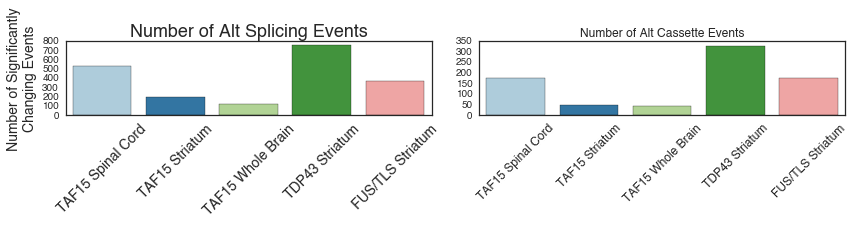

In [24]:
items = alt_cassette_events.groupby(level=["rbp", "cell_type"]).count().sep_score
with dataviz.Figure(os.path.join(img_dir, "total_number_of_events.svg"), figsize=(12,3), tight_layout=True) as fig:
    ax = fig.add_subplot(1,2,1)
    items = significant_events.ix[['taf15', 'tdp43', 'tls']].groupby(level=["rbp", "cell_type"]).count().sep_score
    names = np.array([" ".join([rbp_name_dict[item[0]], cell_type_dict[item[1]]]) for item in items.index])
    sns.barplot(names,
                items.values,
                ci=None,
                palette="Paired",
                hline=.1,
                ax=ax,
                x_order=names
                )
    [tick.set_rotation(45) for tick in ax.get_xticklabels()]
    ax.set_title("Number of Alt Splicing Events", fontsize=18)
    ax.set_ylabel("Number of Significantly\nChanging Events", fontsize=14)
    [tick.set_fontsize(14) for tick in ax.get_xticklabels()]

    ax = fig.add_subplot(1,2,2)
    items = significant_alt_cassette_events.ix[['taf15', 'tdp43', 'tls']].groupby(level=["rbp", "cell_type"]).count().sep_score
    names = np.array([" ".join([rbp_name_dict[item[0]], cell_type_dict[item[1]]]) for item in items.index])
    sns.barplot(names,
                items.values,
                ci=None,
                palette="Paired",
                hline=.1, 
                ax=ax,
                x_order=names)
    [tick.set_rotation(45) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]

    ax.set_title("Number of Alt Cassette Events")
    #ax.set_ylabel("Number of Events")

Figure Legend: Figure Legend: Number of significant alt splicing and alt casssete events in TAF15, TDP43 and FUS/TLS

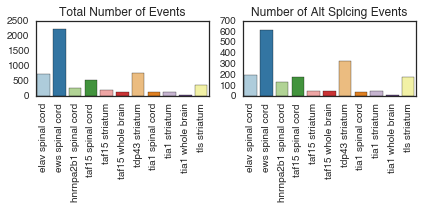

In [25]:
items = alt_cassette_events.groupby(level=["rbp", "cell_type"]).count().sep_score
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3), tight_layout=True) as fig:
    ax = fig.add_subplot(1,2,1)
    items = significant_events.groupby(level=["rbp", "cell_type"]).count().sep_score
    sns.barplot(np.array([" ".join(item) for item in items.index]), items.values, ci=None, palette="Paired", hline=.1, ax=ax)
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_title("Total Number of Events")
    
    ax = fig.add_subplot(1,2,2)
    items = significant_alt_cassette_events.groupby(level=["rbp", "cell_type"]).count().sep_score
    sns.barplot(np.array([" ".join(item) for item in items.index]), items.values, ci=None, palette="Paired", hline=.1, ax=ax)
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_title("Number of Alt Splcing Events")

Figure Legend: Figure Legend: Number of significant alt splicing and alt casssete events in for all knockdowns

#What is the fraction of all events?

In [26]:
num_events = {}
for name, df in significant_events.ix[['taf15', 'tdp43', 'tls']].groupby(level=['rbp', 'cell_type']):
    num_events[name] = df.groupby("splice_type").count().sep_score
    
num_events = pd.DataFrame(num_events)
num_events.columns = pd.MultiIndex.from_tuples(num_events.columns)
num_events = num_events.fillna(0)

fraction_events = num_events / num_events.sum() 
cumsum_events = fraction_events.cumsum()

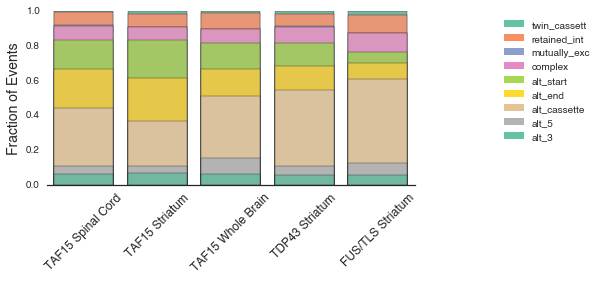

In [27]:

num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "fraction_binding_striatum.svg"), figsize=(6, 4)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    legend_builder = []
    legend_labels = []
    for splice_type, color in izip(reversed(cumsum_events.index), sns.color_palette("Set2", len(cumsum_events.index))):
        names = np.array([" ".join([rbp_name_dict[item[0]], cell_type_dict[item[1]]]) for item in cumsum_events.columns])

        sns.barplot(names, 
                    y=cumsum_events.ix[splice_type], color=color, ax=ax)
        
        legend_builder.append(plt.Rectangle((0,0),.25,.25, fc=color, edgecolor = 'none'))
        legend_labels.append(splice_type)

    sns.despine(ax=ax, left=True)
    
   

    l = ax.legend(legend_builder, 
                  legend_labels, loc=1, ncol = 1, 
                  prop={'size':10}, 
                  bbox_to_anchor=(1.5, 1))
    l.draw_frame(False)
    [tick.set_rotation(45) for tick in ax.get_xticklabels()]
    #Need to change to percent
    ax.set_ylabel("Fraction of Events", fontsize=14)
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]
    


Figure Legend: Fraction of significant alt splcicing events belonging to given group for TAF15, TDP and FUS

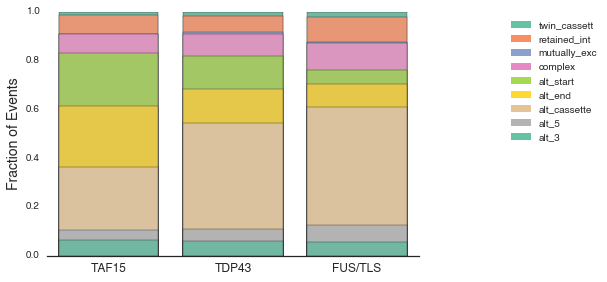

In [28]:
num_rows = 1
num_cols = 1
cumsum_striatum_events = cumsum_events.T.xs("striatum", level=1).T
with dataviz.Figure(os.path.join(img_dir, "fraction_binding_striatum.svg"), figsize=(6, 4)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    legend_builder = []
    legend_labels = []
    for splice_type, color in izip(reversed(cumsum_striatum_events.index), sns.color_palette("Set2", len(cumsum_striatum_events.index))):
        names = np.array([rbp_name_dict[item] for item in cumsum_striatum_events.columns])
        sns.barplot(names, 
                    cumsum_striatum_events.ix[splice_type], 
                    color=color, 
                    ax=ax)
        
        legend_builder.append(plt.Rectangle((0,0),.25,.25, fc=color, edgecolor = 'none'))
        legend_labels.append(splice_type)

    sns.despine(ax=ax, left=True)
    
   

    l = ax.legend(legend_builder, 
                  legend_labels, loc=1, ncol = 1, 
                  prop={'size':10}, 
                  bbox_to_anchor=(1.5, 1))
    l.draw_frame(False)
    [tick.set_rotation(0) for tick in ax.get_xticklabels()]
    #Need to change to percent
    ax.set_ylabel("Fraction of Events", fontsize=14)
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]

In [29]:
os.path.join(img_dir, "num_splicing_events.csv")

'/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/figures/num_splicing_events.csv'

In [30]:
num_events.to_csv(os.path.join(img_dir, "num_splicing_events.csv"))

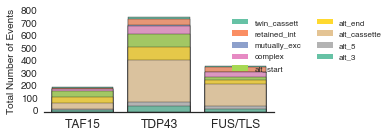

In [31]:
num_rows = 1
num_cols = 1
cumsum_striatum_events = num_events.cumsum().T.xs("striatum", level=1).T
with dataviz.Figure(os.path.join(img_dir, "total_binding_striatum.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    legend_builder = []
    legend_labels = []
    for splice_type, color in izip(reversed(cumsum_striatum_events.index), sns.color_palette("Set2", len(cumsum_striatum_events.index))):
        names = np.array([rbp_name_dict[item] for item in cumsum_striatum_events.columns])
        sns.barplot(names, 
                    cumsum_striatum_events.ix[splice_type], 
                    color=color, 
                    ax=ax)
        
        legend_builder.append(plt.Rectangle((0,0),.25,.25, fc=color, edgecolor = 'none'))
        legend_labels.append(splice_type)

    sns.despine(ax=ax, left=True)
    
   

    l = ax.legend(legend_builder, 
                  legend_labels, loc=1, ncol = 2, 
                  prop={'size':8}, 
                  bbox_to_anchor=(1.5, 1))
    l.draw_frame(False)
    [tick.set_rotation(0) for tick in ax.get_xticklabels()]
    #Need to change to percent
    ax.set_ylabel("Total Number of Events", fontsize=10)
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]

In [32]:
num_events

taf15                         tdp43      tls
             spinal cord striatum whole brain striatum striatum
alt_3                 34       13           8       45       20
alt_5                 24        8          12       37       27
alt_cassette         177       51          45      330      177
alt_end              119       49          20      105       34
alt_start             90       43          19      101       22
complex               44       15          10       69       40
mutually_exc           3        0           0        5        1
retained_int          38       15          12       52       38
twin_cassett           3        3           1       12        8

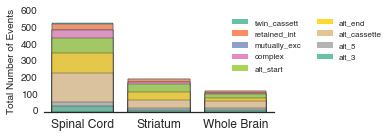

In [33]:
num_rows = 1
num_cols = 1
cumsum_striatum_events = num_events.cumsum().T.ix["taf15"].T
with dataviz.Figure(os.path.join(img_dir, "total_binding_taf15.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    legend_builder = []
    legend_labels = []
    for splice_type, color in izip(reversed(cumsum_striatum_events.index), sns.color_palette("Set2", len(cumsum_striatum_events.index))):
        names = np.array([cell_type_dict[item] for item in cumsum_striatum_events.columns])
        sns.barplot(names, 
                    cumsum_striatum_events.ix[splice_type], 
                    color=color, 
                    ax=ax)
        
        legend_builder.append(plt.Rectangle((0,0),.25,.25, fc=color, edgecolor = 'none'))
        legend_labels.append(splice_type)

    sns.despine(ax=ax, left=True)
    
   

    l = ax.legend(legend_builder, 
                  legend_labels, loc=1, ncol = 2, 
                  prop={'size':8}, 
                  bbox_to_anchor=(1.5, 1))
    l.draw_frame(False)
    [tick.set_rotation(0) for tick in ax.get_xticklabels()]
    #Need to change to percent
    ax.set_ylabel("Total Number of Events", fontsize=10)
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]

Conclusions
---

1. There are about as many splicing events in TAF15 as there are in TDP43 and TLS under some conditions
2. The majority of splicing events are alt cassette, however there appears to be an icrease of alt start and alt end events in TAF15 as compared to other RPBs.  Unknown if this is important

#How do splicing events overlap?

In [34]:
concordent = defaultdict(dict)
discordent = defaultdict(dict)

for rbp_1, df_1 in alt_cassette_events.groupby(level=["rbp", "cell_type"]):
    for rbp_2, df_2 in alt_cassette_events.groupby(level=["rbp", "cell_type"]):
        name1 = "_".join(rbp_1)
        name2 = "_".join(rbp_2)
        
        df_1.index = df_1.index.get_level_values(level="location")
        df_2.index = df_2.index.get_level_values(level="location")
        combined_df = pd.concat({"df1": df_1.sep_score, "df2": df_2.sep_score}, axis=1)
        combined_df = combined_df.dropna()
        if len(combined_df) == 0:
            concordent[name1][name2] = 0
            discordent[name1][name2] = 0
            continue
        concordent_changes = combined_df.apply(lambda x: all(x > 0) or all(x < 0), axis=1)
        discordent_changes = combined_df.apply(lambda x: (x[0] > 0 and x[1] < 0) or (x[0] < 0 and x[1] > 0), axis=1)

        concordent[name1][name2] = sum(concordent_changes)
        discordent[name1][name2] = sum(discordent_changes)

concordent = pd.DataFrame(concordent)
discordent = pd.DataFrame(discordent)

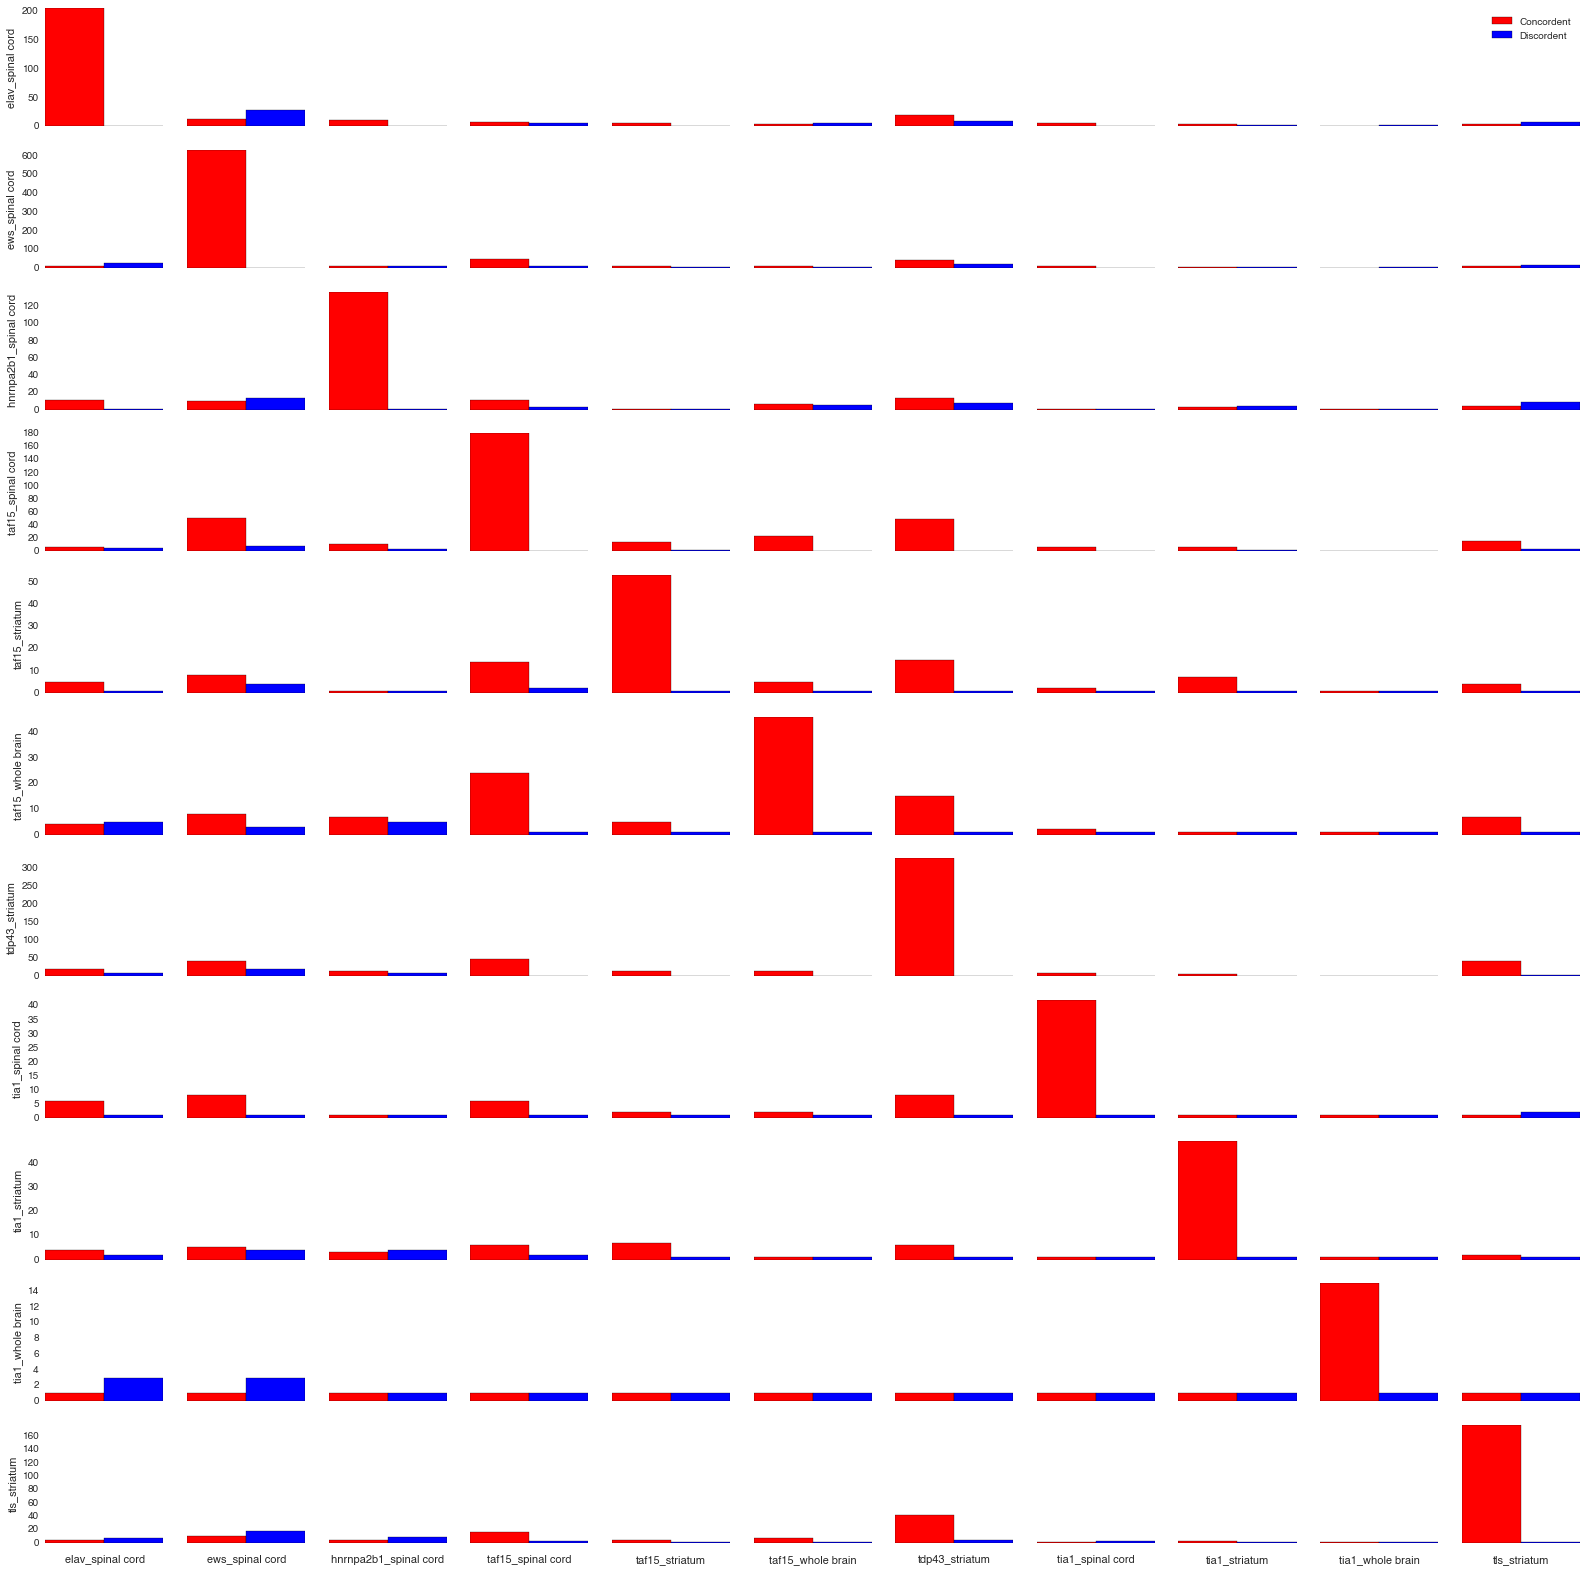

In [35]:
num_rows = len(discordent)
num_cols = len(discordent)
width=.35

with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows), tight_layout=False) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    for x, ((name_1, concordent_row), (name_1, discordent_row)) in enumerate(zip(concordent.iterrows(), discordent.iterrows())):
        for y, ((name_2, concordent_value), (name_2, discordent_value)) in enumerate(zip(concordent_row.iteritems(), discordent_row.iteritems())):
            ax = fig.add_subplot(gs[x,y])
            
            concordent_value = concordent_value + 1 if concordent_value == 0 else concordent_value
            discordent_value = discordent_value + 1 if discordent_value == 0 else discordent_value

            ax.bar([0], [concordent_value], width, color='r')
            ax.bar([width], [discordent_value], width, color='b')
            
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticklabels([])

            ax.set_ylim(0, max(concordent_row.max(), concordent_row.max()))
            if ax.is_first_col():
                ax.set_ylabel(name_1)
            else:
                ax.set_yticklabels([])
            if ax.is_last_row():
                ax.set_xlabel(name_2)
                
            if ax.is_last_col() and ax.is_first_row():
                ax.legend(["Concordent", "Discordent"])
            #ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            #[tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            #[tick.set_fontsize(10) for tick in ax.get_yticklabels()]

In [36]:
interesing_kds = [u'taf15_spinal cord', u'taf15_striatum', u'taf15_whole brain', u'tdp43_striatum', u'tls_striatum']

In [37]:
interesting_concordent = concordent.ix[interesing_kds, interesing_kds]
interesting_discordent = discordent.ix[interesing_kds, interesing_kds]

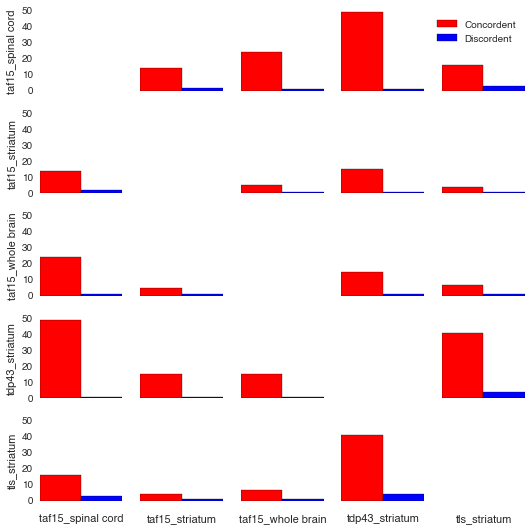

In [38]:
num_rows = len(interesting_concordent)
num_cols = len(interesting_concordent)
width=.35

with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(1.5 * num_cols,1.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    for x, ((name_1, concordent_row), (name_1, discordent_row)) in enumerate(zip(interesting_concordent.iterrows(), interesting_discordent.iterrows())):
        for y, ((name_2, concordent_value), (name_2, discordent_value)) in enumerate(zip(concordent_row.iteritems(), discordent_row.iteritems())):
        
            ax = fig.add_subplot(gs[x,y])
            ax.set_ylim(0, 50)

            if ax.is_first_col():
                ax.set_ylabel(name_1)
            else:
                ax.set_yticklabels([])
            if ax.is_last_row():
                ax.set_xlabel(name_2)
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticklabels([])

            if name_1 == name_2:
                continue
            concordent_value = concordent_value + 1 if concordent_value == 0 else concordent_value
            discordent_value = discordent_value + 1 if discordent_value == 0 else discordent_value

            ax.bar([0], [concordent_value], width, color='r')
            ax.bar([width], [discordent_value], width, color='b')
            
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticklabels([])

            #ax.set_ylim(0, max(concordent_row.drop(name_1).max(), discordent_row.drop(name_1).max()))
            ax.set_ylim(0, 50)

            if ax.is_first_col():
                ax.set_ylabel(name_1)
            else:
                ax.set_yticklabels([])
            if ax.is_last_row():
                ax.set_xlabel(name_2)
                
            if ax.is_last_col() and ax.is_first_row():
                ax.legend(["Concordent", "Discordent"])
            #ax.set_title("{} vs\n{}".format(name1, name2), fontsize=6)
            #[tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            #[tick.set_fontsize(10) for tick in ax.get_yticklabels()]

Figure Legend: Number of Concordent and discordent overlapping events between TAF15, FUs and TLS for all tissue types and knockdowns

#Clustering Actual Events

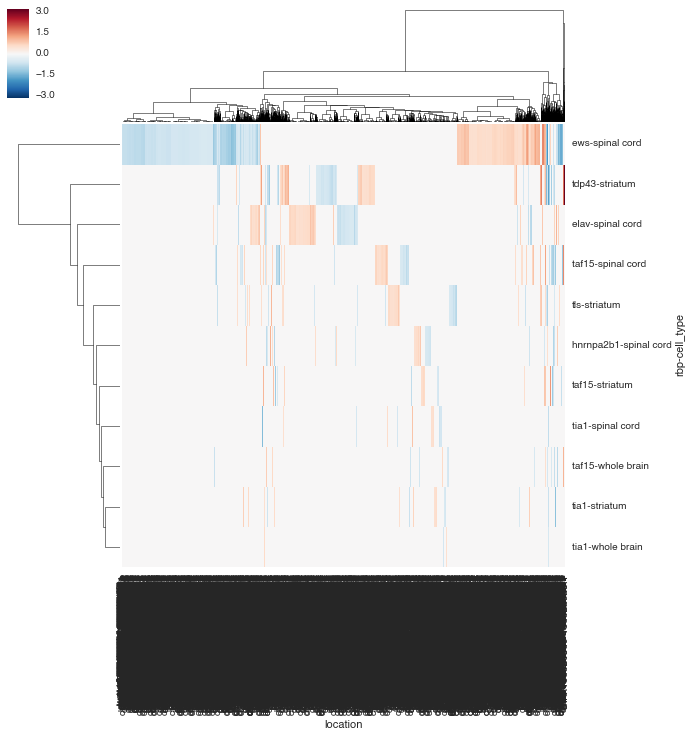

In [39]:
heatmap_prep = all_events.sep_score.unstack()
heatmap_prep = heatmap_prep.fillna(0)
sns.clustermap(heatmap_prep, linewidths=0)

Figure Legend: Clustergram of all significant alt-splcing events, in all mouse knockdowns, blue is excluded splicing event, red is included

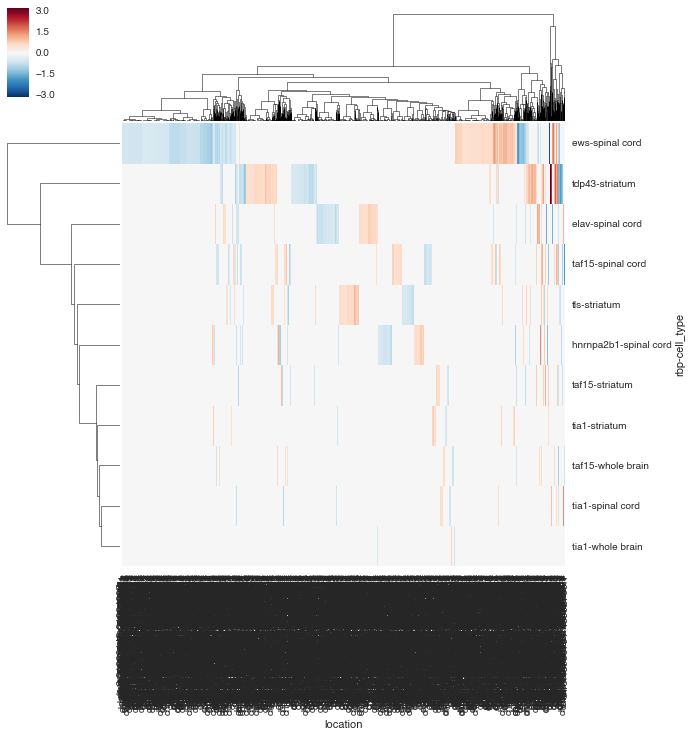

In [40]:
heatmap_prep = alt_cassette_events.sep_score.unstack()
heatmap_prep = heatmap_prep.fillna(0)
sns.clustermap(heatmap_prep, linewidths=0)

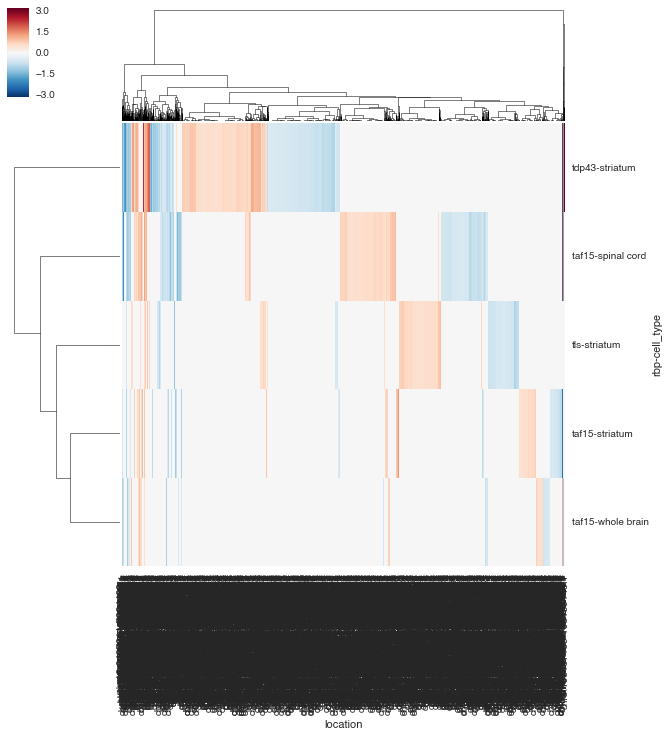

In [41]:
heatmap_prep = all_events.ix[['taf15', 'tdp43', 'tls']]
heatmap_prep = heatmap_prep.sep_score.unstack()
heatmap_prep = heatmap_prep.fillna(0)
sns.clustermap(heatmap_prep, linewidths=0)

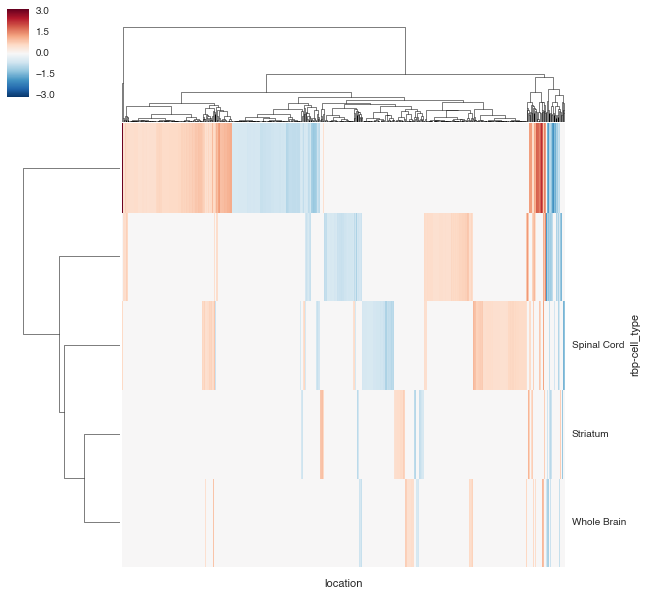

In [42]:
heatmap_prep = alt_cassette_events.ix[['taf15', 'tdp43', 'tls']] 
heatmap_prep = heatmap_prep.sep_score.unstack()
heatmap_prep = heatmap_prep.fillna(0)
sns.clustermap(heatmap_prep, linewidths=0, xticklabels=False, yticklabels=names)
plt.savefig(os.path.join(img_dir, "splicing_events.pdf"))
plt.savefig(os.path.join(img_dir, "splicing_events.svg"))

In [43]:
heatmap_prep = alt_cassette_events.xs("striatum", level="cell_type")

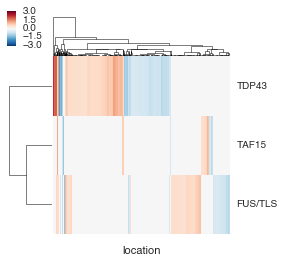

In [44]:
heatmap_prep = alt_cassette_events.xs("striatum", level="cell_type").sort_index().ix[['taf15', 'tdp43', 'tls']] 

heatmap_prep = heatmap_prep.sep_score.unstack()
heatmap_prep = heatmap_prep.fillna(0)
heatmap_prep.index = np.array([rbp_name_dict[item] for item in heatmap_prep.index])
sns.clustermap(heatmap_prep, linewidths=0, xticklabels=False, figsize=(4,4))
plt.savefig(os.path.join(img_dir, "splicing_events_straitum_significant.pdf"))
plt.savefig(os.path.join(img_dir, "splicing_events_straitum_significant.svg"))

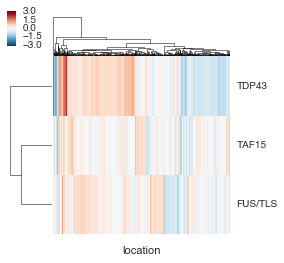

In [45]:
sep_scores = alt_cassette_events_full.xs("striatum", level="cell_type").sort_index().loc(axis=0)[['taf15', 'tdp43', 'tls']].sep_score.unstack()
sep_scores = sep_scores.fillna(0)
sep_scores = sep_scores.T.groupby(level="location").last()

q_values = alt_cassette_events_full.xs("striatum", level="cell_type").sort_index().loc(axis=0)[['taf15', 'tdp43', 'tls']].q_value.unstack()
q_values = q_values.fillna(1)
q_values = q_values.T.groupby(level="location").last()

sep_scores = sep_scores[(sep_scores.abs().max(axis=1) > .5) & (q_values.min(axis=1) <= .05)].T
sep_scores.index = np.array([rbp_name_dict[item] for item in sep_scores.index])

sns.clustermap(sep_scores, linewidths=0, xticklabels=False, figsize=(4,4))
plt.savefig(os.path.join(img_dir, "splicing_events_straitum.pdf"))
plt.savefig(os.path.join(img_dir, "splicing_events_straitum.svg"))

/nas3/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1353: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)


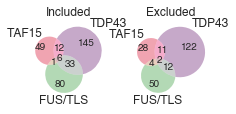

In [46]:
excluded = sep_scores[sep_scores < -.5]
included = sep_scores[sep_scores > .5]

num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "included_excluded_pie_charts.svg"), figsize=(1.5 * num_cols,1.5*num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)

    venn3([included.ix['TAF15'].dropna().keys(),
           included.ix['TDP43'].dropna().keys(),
           included.ix['FUS/TLS'].dropna().keys()],
         set_labels=["TAF15", "TDP43", "FUS/TLS"],
         set_colors=[color_map['taf15'], color_map['tdp43'], color_map['fus']],
         ax=ax)
    ax.set_title("Included")
    
    ax = fig.add_subplot(num_rows, num_cols, 2)

    venn3([excluded.ix['TAF15'].dropna().keys(),
           excluded.ix['TDP43'].dropna().keys(),
           excluded.ix['FUS/TLS'].dropna().keys()],
         set_labels=["TAF15", "TDP43", "FUS/TLS"],
         set_colors=[color_map['taf15'], color_map['tdp43'], color_map['fus']],
         ax=ax)
    ax.set_title("Excluded")
    
    

Figure Legend: Clustergram of all alt cassette events for TAF15, FUS and TDP43 in all tissue types 

#Set up things I need for GO analysis, background expression and GO object

In [47]:
metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/unix_mouse_fet_data_locations_and_annitations.csv")
metadata = metadata[metadata.geo_name != "not_submitted"]
null_bioreps = metadata[metadata['Biological Replicate'].isnull()]
metadata.loc[null_bioreps.index,'Biological Replicate'] = null_bioreps.Location.apply(lambda x: os.path.basename(x).split(".")[0]).values
biorep_info = metadata.groupby('Biological Replicate').first()

all_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/all_counts.txt", index_col=0, skiprows=1)
all_counts.columns = [item.split(".")[0] for item in all_counts.columns]
rpkm = counts_to_rpkm(all_counts)
rpkm = rpkm.T
rpkm = rpkm.ix[biorep_info.index]
flotilla_rpkm = rpkm.copy()

result = []
for index in rpkm.index:
    exp_info = biorep_info.ix[index] 
    result.append([exp_info['rbp'], exp_info['Cell Type'], exp_info['bio_rep'], exp_info['analysis_group'], biorep_info.ix[index].name])
rpkm.index = pd.MultiIndex.from_tuples(result, names=['knockdown', 'cell_type', 'rep', 'analysis_group', 'exp'])
rpkm = rpkm.sortlevel()

#Executing
rpkm = rpkm.drop("PBS", level=0)
rpkm = rpkm.drop("TAF15_ASO_3", level="exp")
rpkm = rpkm.drop("TIA1_Br_1", level="exp")

mapper = {
('ews', 'spinal cord'): ("HTT", "Spinal Cord", 4),
('fus', 'spinal cord'): ("HTT", "Spinal Cord", 6),
('tls', 'striatum'): ("Control Oligo", "Striatum", 1),
('hnrnpa2b1', 'spinal cord'): ("HTT", "Spinal Cord", 7),
('elav', 'spinal cord'): ("HTT", "Spinal Cord", 5),
('taf15', 'spinal cord'): ("HTT", "Spinal Cord", 4),
('taf15', 'striatum'): ("HTT", "Striatum", 2),
('taf15', 'whole brain'): ("HTT", "Whole Brain", 3),
('tdp43', 'striatum'): ("Control Oligo", "Striatum", 1),
('tia1', 'spinal cord'): ("HTT", "Spinal Cord", 5),
('tia1', 'striatum'): ("HTT", "Striatum", 2),
('tia1', 'whole brain'): ("HTT", "Whole Brain", 5),
}

In [48]:
mm9go = GO.mm9GO()

In [53]:
#This takes a few minutes...
all_alt_cassete_events_go = {}
for name, df in significant_alt_cassette_events.groupby(level=['rbp', 'cell_type']):
    try:
        expressed_genes = get_expressed_genes(*name)
        all_alt_cassete_events_go[name] = mm9go.enrichment(gencode_to_ensembl(df.gene_id),
                                               background=expressed_genes
                                               )
    except ValueError as e:
        print name, e
    
all_alt_cassete_events_go = pd.concat(all_alt_cassete_events_go, names=['rbp', 'cell_type', 'go_term_id']).dropna()
all_alt_cassete_events_go = all_alt_cassete_events_go[all_alt_cassete_events_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

('hnrnpa2b1', 'spinal cord') Length of genes examined should not be larger than the total number of genes in organism


In [54]:
sig_changing = pd.concat({"included": significant_alt_cassette_events[significant_alt_cassette_events.sep_score > 0], 
                          "excluded": significant_alt_cassette_events[significant_alt_cassette_events.sep_score < 0]}, names=["change", 'rbp', 'cell_type', "location"])

In [55]:
#This takes a few minutes...
sig_change_go = {}
for name, df in sig_changing.groupby(level=['change', 'rbp', 'cell_type']):
    try:
        expressed_genes = get_expressed_genes(*name[1:])
        sig_change_go[name] = mm9go.enrichment(gencode_to_ensembl(df.gene_id),
                                               background=expressed_genes
                                               )
    except ValueError as e:
        print name, e
sig_change_go = pd.concat(sig_change_go, names=['change', 'rbp', 'cell_type', 'go_term_id'])
sig_change_go = sig_change_go[sig_change_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

('excluded', 'hnrnpa2b1', 'spinal cord') Length of genes examined should not be larger than the total number of genes in organism
('included', 'hnrnpa2b1', 'spinal cord') Length of genes examined should not be larger than the total number of genes in organism


#All Alt-Cassete Events

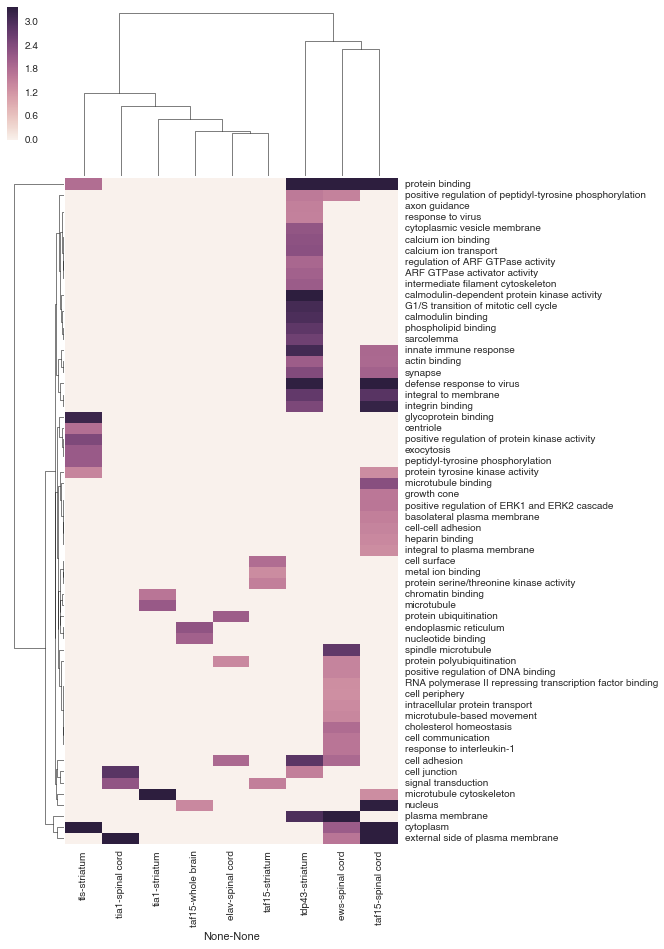

In [64]:
plot_go_enrichment(all_alt_cassete_events_go, figsize=(7,15))

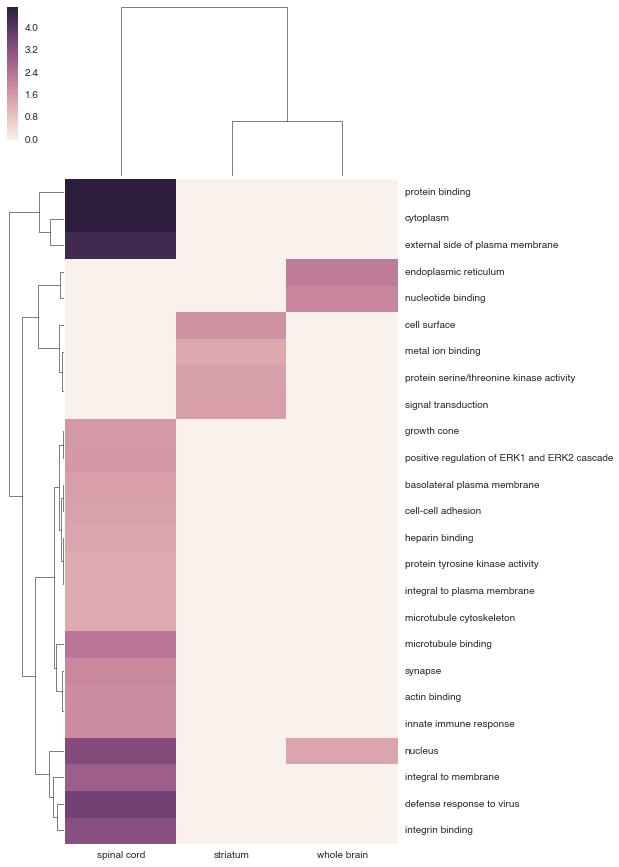

In [65]:
plot_go_enrichment(all_alt_cassete_events_go.ix['taf15'], figsize=(7,15))

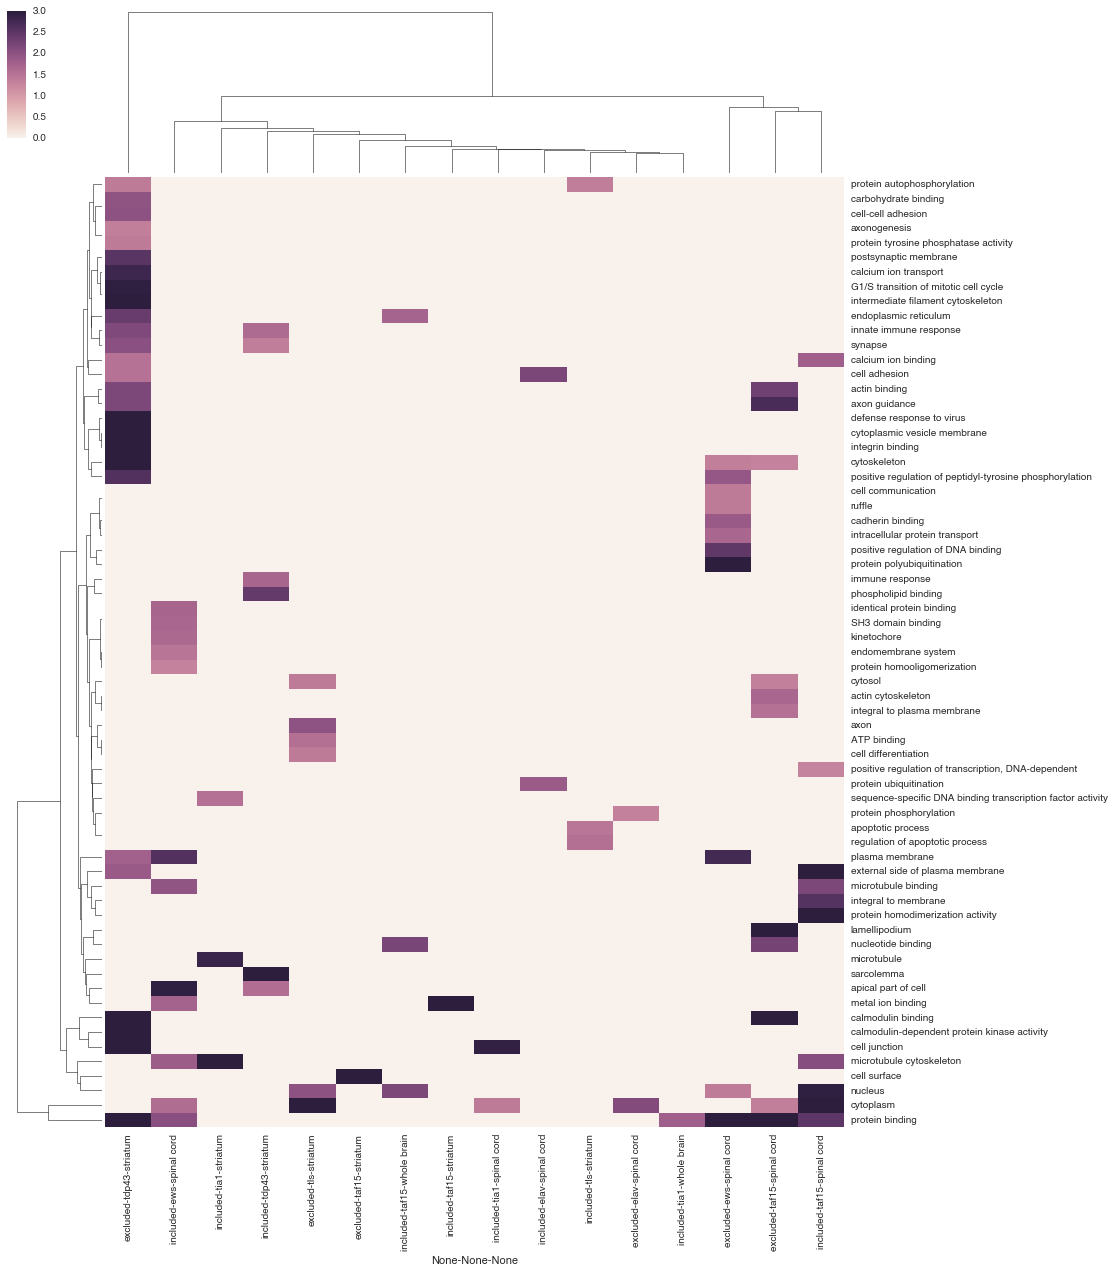

In [66]:
plot_go_enrichment(sig_change_go, figsize=(15,20))

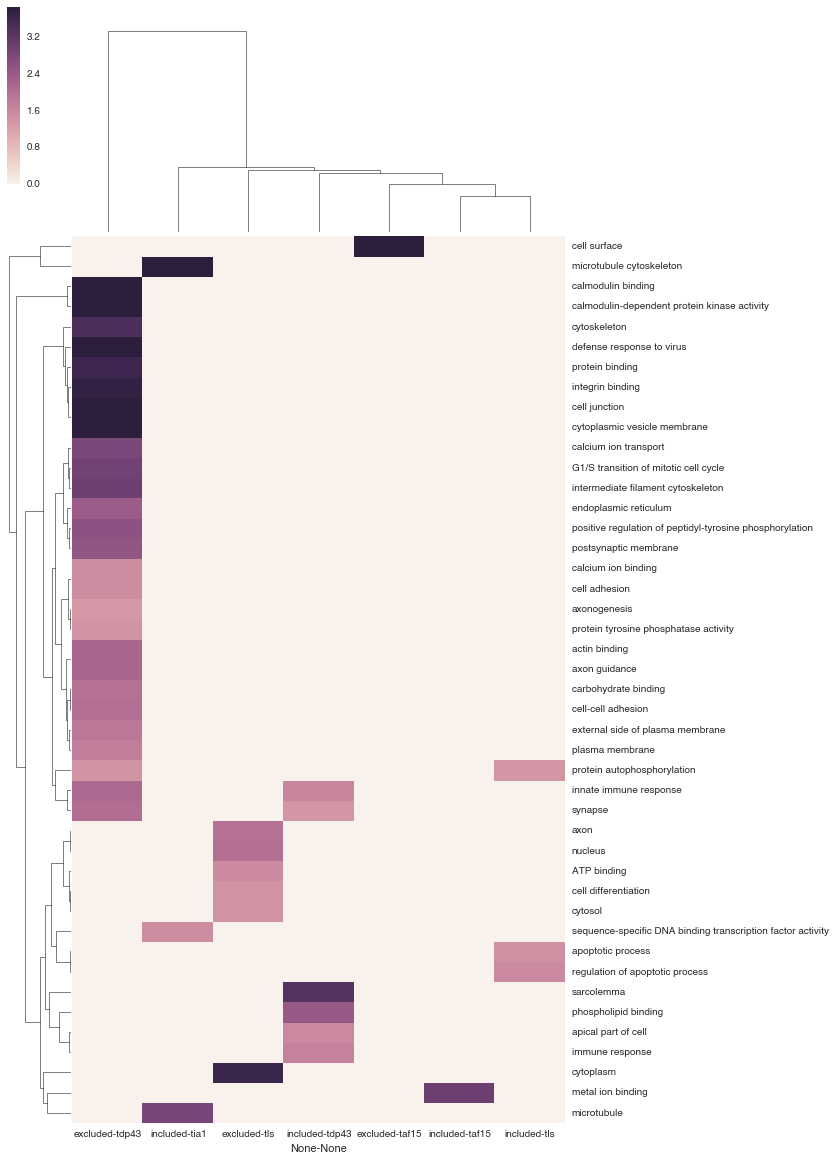

In [59]:
plot_go_enrichment(sig_change_go.xs("striatum", level="cell_type"), figsize=(10,20))

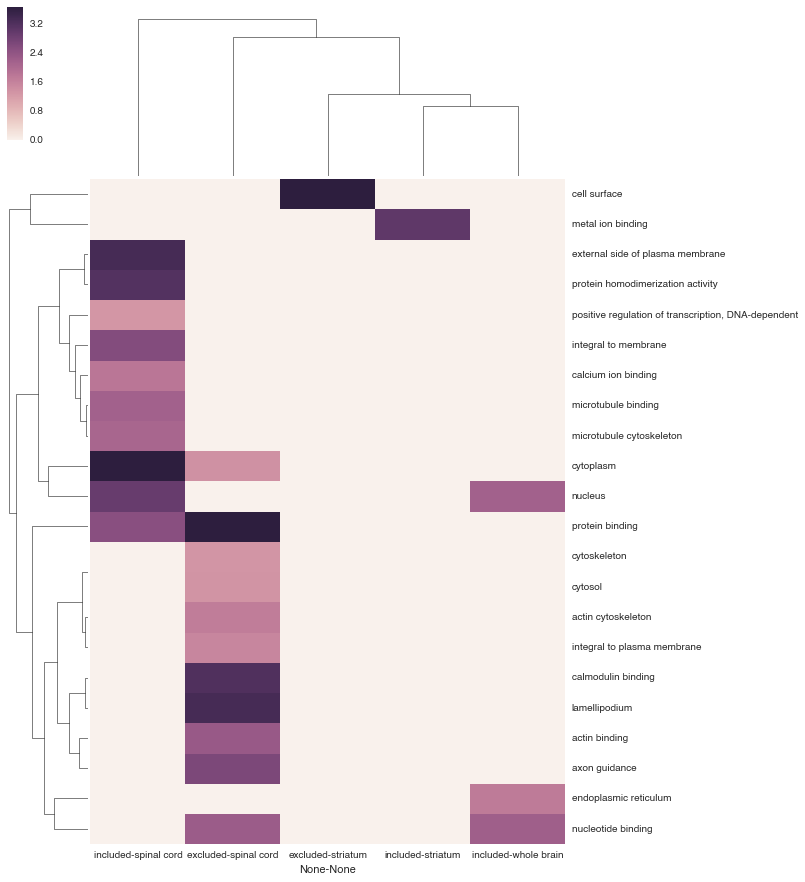

In [67]:
plot_go_enrichment(sig_change_go.xs("taf15", level="rbp"), figsize=(10,15))

#What do the distribution of sep scores look like for significant changes?

/nas3/gpratt/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


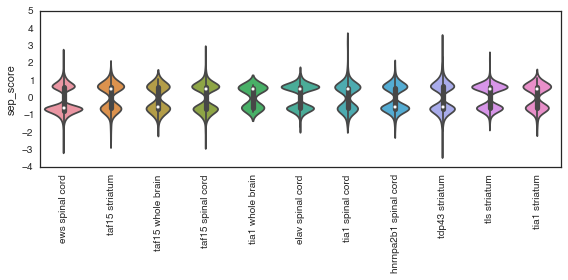

In [69]:
with dataviz.Figure(os.path.join(img_dir, "sep_score_distributions.svg"), figsize=(8,4)) as fig:
    ax = fig.add_subplot(1,1,1)
    g = [" ".join(item[:-1]) for item in all_events.index]
    sns.violinplot(all_events.sep_score, groupby=g, ax=ax)
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]

Figure Legend: Violin Plot of distributon of sep scores for all knockdown experiments

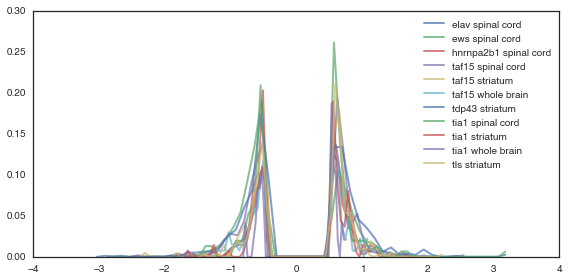

In [70]:
with dataviz.Figure(os.path.join(img_dir, "sep_score_distributions_pdf.svg"), figsize=(8,4)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in all_events.sep_score.groupby(level=['rbp', 'cell_type']):
        dataviz.plot_pdf(df, label=" ".join(name), ax=ax, alpha=.7, linewidth=2)
    ax.legend()

Figure Legend: PDF Plot of distributon of sep scores for all knockdown experiments

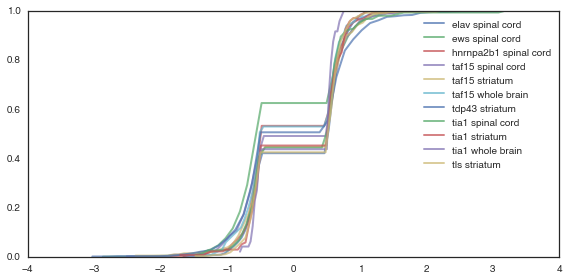

In [71]:
with dataviz.Figure(os.path.join(img_dir, "sep_score_distributions_cdf.svg"), figsize=(8,4)) as fig:
    ax = fig.add_subplot(1,1,1)
    for name, df in all_events.sep_score.groupby(level=['rbp', 'cell_type']):
        dataviz.plot_cdf(df, label=" ".join(name), ax=ax, alpha=.7, linewidth=2)
    ax.legend()

Figure Legend: CDF Plot of distributon of sep scores for all knockdown experiments

Conclusions
---
1. Total Distribution of splicing events isn't very different, except for ews spinal cord, which has a few more excluded events

#How many specific event locations (give or take a few hundred base pairs have taf15 binding sites?

#How many events overlap binding sites in TAF15?

In [72]:
regions = OrderedDict()
regions["cds"] = "CDS"
regions["three_prime_utrs"] = "3' UTR"
regions["five_prime_utrs"] = "5' UTR"
regions["proxintron500"] = "Proximal\nIntron"
regions["distintron500"] = "Distal\nIntron"

def move_name(interval):
    interval.name = interval[12]
    return interval

In [73]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")
rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "tls": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}

for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, "overlapping", 
                                    regions, "assigned", nrand=0, species="mm9")
    assigned_peaks[rbp] = cluster_regions 
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

There are a total 155599 clusters I'll examine
For region: cds found 13193 that overlap and 142406 that don't
For region: three_prime_utrs found 10705 that overlap and 131701 that don't
For region: five_prime_utrs found 944 that overlap and 130757 that don't
For region: proxintron500 found 21211 that overlap and 109546 that don't
For region: distintron500 found 109329 that overlap and 217 that don't
After assigning 217 un-categorized regions
There are a total 69657 clusters I'll examine
For region: cds found 521 that overlap and 69136 that don't
For region: three_prime_utrs found 2999 that overlap and 66137 that don't
For region: five_prime_utrs found 194 that overlap and 65943 that don't
For region: proxintron500 found 8425 that overlap and 57518 that don't
For region: distintron500 found 57457 that overlap and 61 that don't
After assigning 61 un-categorized regions
There are a total 44610 clusters I'll examine
For region: cds found 1470 that overlap and 43140 that don't
For region: t

In [74]:
all_events_significance = defaultdict(dict)
for (spliced_rbp, cell_type), splicng_df in all_events.groupby(level=['rbp', 'cell_type']):
    expressed_genes = get_expressed_genes(spliced_rbp, cell_type)
    for (bound_rbp, region), region_df in binding_df.groupby(level=['rbp', 'region']):
        total_bound = len(region_df)
        total_spliced = len(splicng_df)
        both = len(region_df.index.get_level_values(level="gene_id") & splicng_df.gene_id)
        total = len(expressed_genes)
        test_result = hypergeom.sf(both, total, total_bound, total_spliced)
        all_events_significance[(spliced_rbp, cell_type)][(bound_rbp, region)] = test_result
        
all_events_significance = pd.DataFrame(all_events_significance).dropna(axis=1)
all_events_significance[all_events_significance > .05 / (len(all_events_significance.columns) * len(all_events_significance.index))] = 1

In [75]:
len(all_events_significance.columns), len(all_events_significance.index)

(10, 21)

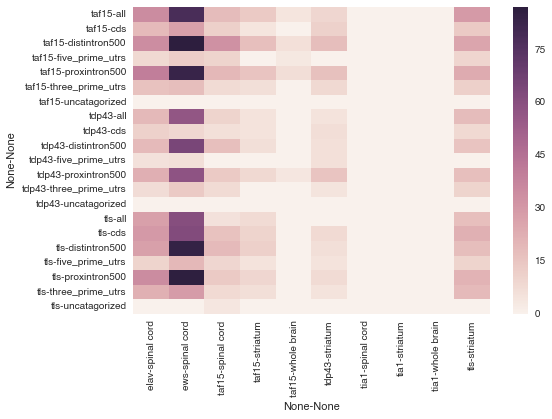

In [76]:
sns.heatmap(-1 * np.log10(all_events_significance))

Figure Legend: -1*log10(hypergeometric distribution) of genes that have an alt splicing event, and genes that are bound by the given RBP in the specificed region

In [77]:
alt_cassette_events_significance = defaultdict(dict)
for (spliced_rbp, cell_type), splicng_df in alt_cassette_events.groupby(level=['rbp', 'cell_type']):
    expressed_genes = get_expressed_genes(spliced_rbp, cell_type)
    for (bound_rbp, region), region_df in binding_df.groupby(level=['rbp', 'region']):
        total_bound = len(region_df)
        total_spliced = len(splicng_df)
        both = len(region_df.index.get_level_values(level="gene_id") & splicng_df.gene_id)
        total = len(expressed_genes)
        test_result = hypergeom.sf(both, total, total_bound, total_spliced)
        alt_cassette_events_significance[(spliced_rbp, cell_type)][(bound_rbp, region)] = test_result
        
alt_cassette_events_significance = pd.DataFrame(alt_cassette_events_significance).dropna(axis=1)
alt_cassette_events_significance[alt_cassette_events_significance > .05 / (21 * 10)] = 1

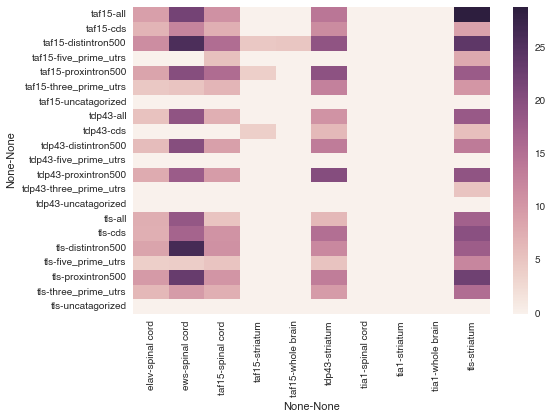

In [78]:
sns.heatmap(-1 * np.log10(alt_cassette_events_significance))

Figure Legend: -1*log10(hypergeometric distribution) of genes that have an alt cassette event, and genes that are bound by the given RBP in the specificed region

In [79]:
def format_bed_from_location(array_interval):
    chrom, loc, strand = array_interval.split(":")
    start, stop = loc.split("-")
    return map(str, [chrom, start, stop, 0, 0, strand, chrom])

In [80]:
# alt_cassette_events_significance = defaultdict(dict)

# for name, df in alt_cassette_events.groupby(level=["rbp", "cell_type"]):
#     array_regions = pybedtools.BedTool([pybedtools.interval_constructor(format_bed_from_location(array_interval)) for array_interval in df.index.get_level_values(level="location")]).sort().saveas()
#     for rbp in rbps:
#         total_bound = len(rbps[rbp])
#         total_spliced = len(array_regions)
#         both = len(array_regions.intersect(rbps[rbp], s=True, u=True))
#         total = len(expressed_genes)
#         print name, rbp, both, total, total_bound, total_spliced
#         test_result = hypergeom.sf(both, total, total_bound, total_spliced)
#         alt_cassette_events_significance[name][rbp] = test_result
        
#alt_cassette_events_significance = pd.DataFrame(alt_cassette_events_significance).dropna(axis=1)
#alt_cassette_events_significance[alt_cassette_events_significance > .05 / (21 * 10)] = 1

In [81]:
#sns.heatmap(-1 * np.log10(alt_cassette_events_significance))

Conclusions:
----
1. TIA1 isn't an important splicing factor and can be dropped out of this analysis
2. TLS spliced sites are highly bound by TAF15. The opposite is not totally true
3. TAF15 splicing is un-regulated by RBPs in Straitum and whole brain, but may be important in splinal cord
4. ELAV, EWS, TDP43 and FUS all apparently cross-react and may cross-regulate according to binding analysis.

#What about auto/cross-regulation?

In [82]:
unstacked_binding = binding_df.unstack()
unstacked_binding = unstacked_binding.rename_axis(gene_id_to_name, axis=1)
unstacked_binding[['Taf15', 'Tardbp', 'Fus']]

gene_id                 Taf15  Tardbp  Fus
rbp   region                              
taf15 all                   7      13   16
      cds                 NaN       2    1
      distintron500         4     NaN    5
      five_prime_utrs     NaN     NaN  NaN
      proxintron500         3     NaN   10
      three_prime_utrs    NaN      11  NaN
      uncatagorized       NaN     NaN  NaN
tdp43 all                  10       7    8
      cds                 NaN       1  NaN
      distintron500         8     NaN    2
      five_prime_utrs     NaN     NaN  NaN
      proxintron500         2     NaN    5
      three_prime_utrs    NaN       6    1
      uncatagorized       NaN     NaN  NaN
tls   all                  26      18    8
      cds                   5       5    2
      distintron500        16     NaN  NaN
      five_prime_utrs     NaN     NaN  NaN
      proxintron500         4     NaN    5
      three_prime_utrs      1      13    1
      uncatagorized       NaN     NaN  NaN

Figure Legend: Cross-binding of TAF15, TDP43 and TLS the number of times the column binds the row, and where that binding occurs

So they all do bind each other, I don't think expression is significantly changed, but I'll have to check in another thing

In [83]:
all_events[all_events.gene_name.isin(['Tardbp', 'Fus', "Taf15"])].gene_name

rbp        cell_type    location                  
ews        spinal cord  chr7:135117948-135119401:+      Fus
                        chr7:135116284-135117913:+      Fus
taf15      striatum     chr11:83302547-83320242:+     Taf15
           whole brain  chr7:135116284-135117913:+      Fus
           spinal cord  chr7:135117948-135119401:+      Fus
tia1       whole brain  chr7:135116264-135119422:+      Fus
elav       spinal cord  chr7:135117948-135119401:+      Fus
hnrnpa2b1  spinal cord  chr7:135116284-135117913:+      Fus
tdp43      striatum     chr7:135117948-135119401:+      Fus
                        chr7:135116284-135117913:+      Fus
tls        striatum     chr7:135116284-135117913:+      Fus
Name: gene_name, dtype: object

Figure Legend: Splicing events occuring in other FET family members and the knockdown doing it

Conclusions
--
1. There is some regulation of Fus for all the other RBPs
2. Taf15 only regulates itself, badly, and Tdp-43 doesn't at all
3. Importantly weren't many events that were even assayed in TDP-43, FUS and TAF15, only one or two each.  Could be missing things. This conclusion was drawn from Steph's analysis of the data the all_events tab of Dropbox/TAF15/Data/SplicingAnalysis_array/03262013/taf15_tdp43_fus_ewssc_summary.xlsx

#Lets make read density plots around skipped exons

In [84]:
exons = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_exons.bed")

#Get Miso SE events
#miso_alt_splicing_events = pybedtools.BedTool("/home/gpratt/data/miso/mm9/mm9/SE.mm9.gff3")
#miso_alt_splicing_events = miso_alt_splicing_events.filter(lambda interval: interval[2] == "gene").sort().saveas()

#Once I get the rest of this built I'll go back and build in the proper events
#all_array_annotated_events = pd.read_table("/nas3/shuelga/projects/taf15_splicing/TAF15_TDP43_FUS_EWSsc_omniviewer.txt")


Check if miso events overlap with the omnivier events and join omniver events on miso events
It doesn't, via some simple intersect bed commands that I got rid of already, something is wrong with the mouse miso annotations so I'm falling back on using arrays 

In [85]:
#print len(array_alt_splicing_events), len(miso_alt_splicing_events)


Miso annotations don't work, they aren't detailed enough, the next best thing is to look at all exons that fall between the annotated event and use those as the locations of taf15 binding

In [86]:
import HTSeq

location_to_gene_id = {index[-1]: item for index, item in alt_cassette_events.gene_id.iteritems()}

def format_bed(array_format):
    chrom, loc, strand = array_format.name.split(":")
    start, stop = loc.split("-")
    return map(str, [chrom, start, stop, array_format.name, 0, strand, chrom, array_format.start_internal, array_format.stop_internal])

# def format_bed(array_format):
#     chrom, loc, strand = array_format.split(":")
#     start, stop = loc.split("-")
#     return [chrom, start, stop, array_format, "0", strand]

def get_bam_coverage(bamfile):
    """
    
    Given a bam file returns a properly covered htseq coverage file (this is slow)
    
    """
    bam = HTSeq.BAM_Reader(bamfile)
    coverage = HTSeq.GenomicArray("auto", typecode="i", stranded=True)
    for read in bam:
        if read.aligned:
            for cigop in read.cigar:
                if cigop.type != "M":
                    continue
                coverage[cigop.ref_iv] += 1
    return coverage

def get_bam_counts(bamfile):
    bam = HTSeq.BAM_Reader(bamfile)
    coverage = HTSeq.GenomicArray("auto", typecode="i")
    for read in bam:
        read.iv.length = 1
        if read.aligned:
            coverage[read.iv] += 1
    return coverage

def bed_to_genomic_interval(bed):
    for interval in bed:
        yield HTSeq.GenomicInterval(interval.chrom, interval.start, interval.stop, interval.strand)

def adjust_width(interval):
    width = 250
    interval.start -= width
    interval.stop += width
    return interval

def is_protein_coding(interval):
    return interval.name in protein_coding_genes.index

def gff_to_bed(gff_handle):
    for interval in gff_handle:
        yield pybedtools.create_interval_from_list([interval.chrom, 
                                                 str(interval.start),
                                                 str(interval.stop),
                                                 interval.attributes['gene_id'][0], 
                                                 "0",
                                                 interval.strand])

def get_densities(intervals, coverage):
    for bed_interval, interval in izip(intervals, bed_to_genomic_interval(intervals)):
        
        density = np.fromiter(coverage[interval], dtype="i")
        if interval.strand == "-":
            density = density[::-1]
        yield {bed_interval.name: density}
   
def check_same_gene(interval):
    return location_to_gene_id[interval.name] == interval[9]

def format_bed(array_format):
    chrom, loc, strand = array_format.name.split(":")
    start, stop = loc.split("-")
    return map(str, [chrom, start, stop, array_format.name, "0", strand, array_format.start_internal, array_format.stop_internal])

def create_array_exon_overlap_tool(array_locations):
    """
    Given a list of array based location returns a bedtool with all exons within those locations
    for creation of splicing density plot
    """
    
    #to clean this up make the array id overlap only with exons from the same gene, this is already assumed for other analyzies anyway
    bed_list = [pybedtools.interval_constructor(format_bed(array_interval)) for name, array_interval in array_locations.iterrows()]
    return pybedtools.BedTool(bed_list).sort().saveas()

def get_mapping_intervals(interval):
    """
    given the crazy formatted spliced exon thing returns the interval to get coverage from
    when plotting around regions
    """
    LEN_IN_INTRON = 300
    LEN_IN_EXON = 50
    cassette_start = int(float(interval[6]))
    cassette_stop  = int(float(interval[7]))
    
    #If there is no overlap with gencode genes...
    if cassette_start == -1:
        return {}

    if interval.strand == "+":
        result = {
        "upstream_exon" : [interval.chrom, interval.start - LEN_IN_EXON, interval.start + LEN_IN_INTRON, interval.name, "0", interval.strand],
        "downstream_exon":  [interval.chrom, interval.stop - LEN_IN_INTRON, interval.stop + LEN_IN_EXON, interval.name, "0", interval.strand],
        "upstream_cassette": [interval.chrom, cassette_start - LEN_IN_EXON, cassette_start + LEN_IN_INTRON, interval.name, "0", interval.strand],
        "downstream_cassette": [interval.chrom, cassette_stop - LEN_IN_INTRON, cassette_stop + LEN_IN_EXON, interval.name, "0", interval.strand],
        }
    elif interval.strand == "-":
        result = {
        "downstream_exon": [interval.chrom, interval.start - LEN_IN_EXON, interval.start + LEN_IN_INTRON, interval.name, "0", interval.strand],
        "upstream_exon": [interval.chrom, interval.stop - LEN_IN_INTRON, interval.stop + LEN_IN_EXON, interval.name, "0", interval.strand],
        "downstream_cassette": [interval.chrom, cassette_start - LEN_IN_INTRON, cassette_start + LEN_IN_EXON, interval.name, "0", interval.strand],
        "upstream_cassette": [interval.chrom, cassette_stop - LEN_IN_EXON, cassette_stop + LEN_IN_INTRON, interval.name, "0", interval.strand],
    }
    else:
        raise Exception

    return {name: pybedtools.interval_constructor(map(str, interval)) for name, interval in result.items() }


def get_mapping_tools(joined_files):
    """
    Given a bedtool generated from joining an array file and a exon file returns back 
    all intervals to extract region information from
    """
    mapping_intervals = defaultdict(list)
    for interval in joined_files:
        for name, interval in get_mapping_intervals(interval).items():
            mapping_intervals[name].append(interval)

    return {name: pybedtools.BedTool(intervals) for name, intervals in mapping_intervals.items() }

def density_to_df(density):

    """
    
    Given a density generator returns a DF with properly labeled axes
    rows being IDs and columns being bases
    
    """
    super_dict = {}
    for d in density:
        for k, v in d.iteritems():
            super_dict[k] = v
    return pd.DataFrame(super_dict).T



def create_array_exon_overlap_tool(array_locations):
    """
    Given a list of array based location returns a bedtool with all exons within those locations
    for creation of splicing density plot
    """
    
    #to clean this up make the array id overlap only with exons from the same gene, this is already assumed for other analyzies anyway
    return pybedtools.BedTool([pybedtools.interval_constructor(format_bed(array_interval)) for name, array_interval in array_locations.iterrows()])


In [87]:
bam_files = {"taf15": "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v1/TAF15_WholeBrain.bam",
             "tdp43": "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v1/TDP43_WholeBrain.bam",
             "tls" : "/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v1/TLS_WholeBrain.bam"}

In [101]:
coverage = {name: get_bam_coverage(location) for name, location in bam_files.items()}

In [102]:
#Doing this shit really hacky like, getting all classes of regulated events
event_matrix = significant_alt_cassette_events.sep_score.unstack().fillna(0).T

In [103]:
plotting_order = OrderedDict()
plotting_order['upstream_exon'] = np.arange(-50, 300)
plotting_order['upstream_cassette'] = np.arange(-50, 300)[::-1]
plotting_order['downstream_cassette'] = np.arange(-50, 300)
plotting_order['downstream_exon'] = np.arange(-50, 300)[::-1]

#Here is where we actually can plot the distributions

In [104]:
usable_splicing_datasets = [col for col in event_matrix.columns if col[0] in coverage]
num_cols = 4
num_rows = len(usable_splicing_datasets)

#with dataviz.Figure(os.path.join(img_dir, "distributions_around_alt_cassete.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
gs = gridspec.GridSpec(num_rows, num_cols)

for y, col in enumerate(usable_splicing_datasets):
    rbp = col[0]
    if rbp not in coverage:
        continue
    rbp_of_interest = event_matrix[col] 
    activated = rbp_of_interest[rbp_of_interest > 0]
    repressed = rbp_of_interest[rbp_of_interest < 0]
    unchanged = rbp_of_interest[rbp_of_interest == 0]

    activated_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[activated.index]))
    repressed_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[repressed.index]))
    unchanged_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[unchanged.index]))

    for x, (region, x_loc) in enumerate(plotting_order.items()):
        ax = fig.add_subplot(gs[y,x])

        ax.plot(x_loc, density_to_df(get_densities(activated_tools[region], coverage[rbp])).mean(), alpha=.7, label="Included")
        ax.plot(x_loc, density_to_df(get_densities(repressed_tools[region], coverage[rbp])).mean(), alpha=.7, label="Excluded")
        ax.plot(x_loc, density_to_df(get_densities(unchanged_tools[region], coverage[rbp])).mean(), alpha=.7, label="Unchanging")
        ax.set_ylim(0, 3.0)
        ax.set_xlabel(region + "\nDistance from Splice Site\n(bp)")

        if not ax.is_first_col():
            sns.despine(ax=ax, left=True)
            ax.set_yticklabels([])
        else: 
            sns.despine(ax=ax)
            ax.set_ylabel(" ".join(col) + "\nMean Coverage" )


        if ax.is_first_row() and ax.is_last_col():
            ax.legend(bbox_to_anchor=(1.5, 1))

Figure Legend: Mean Read Densities around annotated splciing events for upstream 5' SS, cassete exon 3' and '5 SS and downstream 3' SS.  For TAF15, FUS and TDP43

#If we normalize out varying read depths per sample what does it look like? 
Ie. We just want to know specific binding patterns

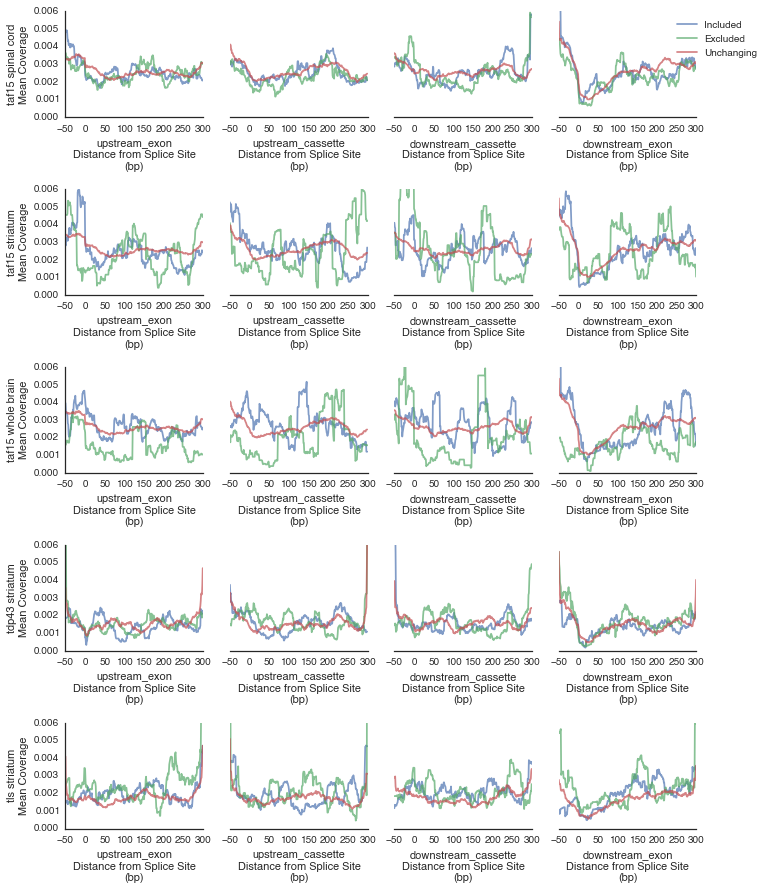

In [105]:
usable_splicing_datasets = [col for col in event_matrix.columns if col[0] in coverage]
num_cols = 4
num_rows = len(usable_splicing_datasets)

with dataviz.Figure(os.path.join(img_dir, "distributions_around_alt_cassete_profile.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    for y, col in enumerate(usable_splicing_datasets):
        rbp = col[0]
        if rbp not in coverage:
            continue
        rbp_of_interest = event_matrix[col] 
        activated = rbp_of_interest[rbp_of_interest > 0]
        repressed = rbp_of_interest[rbp_of_interest < 0]
        unchanged = rbp_of_interest[rbp_of_interest == 0]

        activated_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[activated.index]))
        repressed_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[repressed.index]))
        unchanged_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[unchanged.index]))

        for x, (region, x_loc) in enumerate(plotting_order.items()):
            ax = fig.add_subplot(gs[y,x])

            activated_df = density_to_df(get_densities(activated_tools[region], coverage[rbp]))
            activated_df = activated_df.div(activated_df.sum(axis=1), axis=0).fillna(0)
            
            repressed_df = density_to_df(get_densities(repressed_tools[region], coverage[rbp]))
            repressed_df = repressed_df.div(repressed_df.sum(axis=1), axis=0).fillna(0)

            unchanged_df = density_to_df(get_densities(unchanged_tools[region], coverage[rbp]))
            unchanged_df = unchanged_df.div(unchanged_df.sum(axis=1), axis=0).fillna(0)
  
            
            ax.plot(x_loc, activated_df.mean(), alpha=.7, label="Included")
            ax.plot(x_loc, repressed_df.mean(), alpha=.7, label="Excluded")
            ax.plot(x_loc, unchanged_df.mean(), alpha=.7, label="Unchanging")
            ax.set_ylim(0, .006)
            ax.set_xlabel(region + "\nDistance from Splice Site\n(bp)")
            
            if not ax.is_first_col():
                sns.despine(ax=ax, left=True)
                ax.set_yticklabels([])
            else: 
                sns.despine(ax=ax)
                ax.set_ylabel(" ".join(col) + "\nMean Coverage" )
                
                
            if ax.is_first_row() and ax.is_last_col():
                ax.legend(bbox_to_anchor=(1.5, 1))

Figure Legend: Densities normalized by read covered around region for annotated splciing events for upstream 5' SS, cassete exon 3' and '5 SS and downstream 3' SS.  For TAF15, FUS and TDP43

In [106]:
def get_significant_sites(foreground_df, background_df):
    targets = (foreground_df > 0).sum() 
    non_targets = foreground_df.count() - targets

    unchanged_targets = (background_df > 0).sum() 
    unchanged_non_targets = background_df.count() - targets

    result = []
    for true_targets, true_nontargets, unchanged_targets, unchanged_non_targets in zip(targets, non_targets, unchanged_targets, unchanged_non_targets):
        result.append(scipy.stats.fisher_exact([[true_targets, true_nontargets], [unchanged_targets, unchanged_non_targets]])[1])
    
    result = np.array(result)
    significant = np.where(result < (.05 / 350))
    return significant

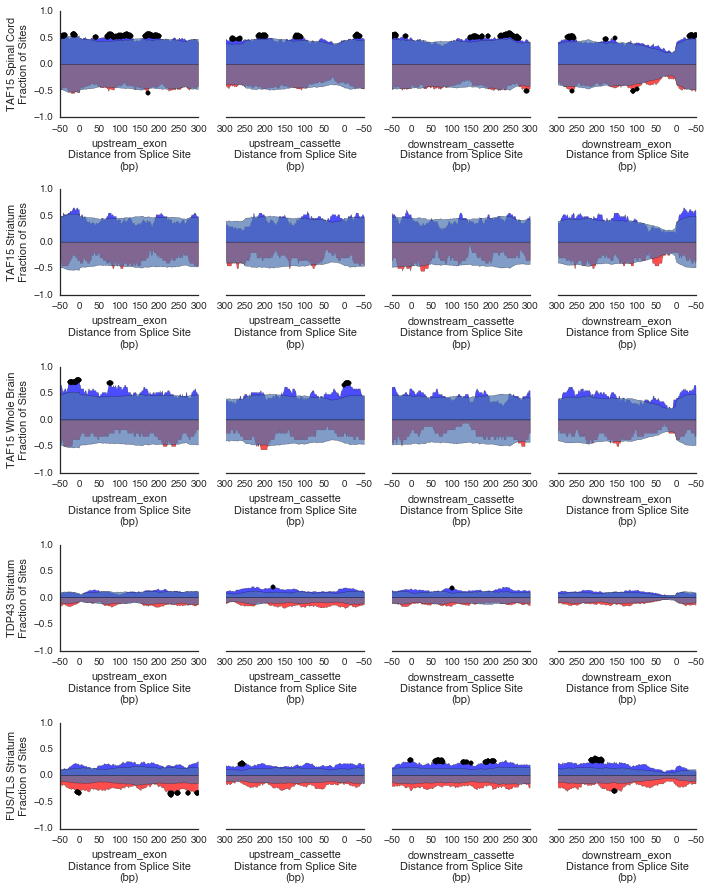

In [107]:
usable_splicing_datasets = [col for col in event_matrix.columns if col[0] in coverage]
num_cols = 4
num_rows = len(usable_splicing_datasets)

with dataviz.Figure(os.path.join(img_dir, "distributions_around_alt_cassete_profile.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    for y, col in enumerate(usable_splicing_datasets):
        rbp = col[0]
        if rbp not in coverage:
            continue
        rbp_of_interest = event_matrix[col] 
        activated = rbp_of_interest[rbp_of_interest > 0]
        repressed = rbp_of_interest[rbp_of_interest < 0]
        unchanged = rbp_of_interest[rbp_of_interest == 0]

        activated_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[activated.index]))
        repressed_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[repressed.index]))
        unchanged_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[unchanged.index]))

        for x, (region, x_loc) in enumerate(plotting_order.items()):
            ax = fig.add_subplot(gs[y,x])
            activated_df = density_to_df(get_densities(activated_tools[region], coverage[rbp]))
            activated_plotter = (activated_df > 0).sum() / activated_df.count()

            repressed_df = density_to_df(get_densities(repressed_tools[region], coverage[rbp]))
            repressed_plotter = (repressed_df > 0).sum() / repressed_df.count()

            unchanged_df = density_to_df(get_densities(unchanged_tools[region], coverage[rbp]))
            unchanged_plotter = (unchanged_df > 0).sum() / unchanged_df.count()


            ax.fill_between(x_loc, 0, activated_plotter, alpha=.7, label="Included", facecolor="blue")
            ax.fill_between(x_loc, 0, repressed_plotter * -1, alpha=.7, label="Excluded", facecolor="red")

            ax.fill_between(x_loc, 0, unchanged_plotter, alpha=.7, label="Unchanging")
            ax.fill_between(x_loc, 0, unchanged_plotter * -1, alpha=.7, label="Unchanging")

            significant_activated = get_significant_sites(activated_df, unchanged_df)[0]
            significant_repressed = get_significant_sites(repressed_df, unchanged_df)[0]
            ax.scatter(x_loc[significant_activated], activated_plotter.ix[significant_activated].values, color='black')
            ax.scatter(x_loc[significant_repressed], repressed_plotter.ix[significant_repressed].values * -1, color='black')
            ax.set_xlabel(region + "\nDistance from Splice Site\n(bp)")
            ax.set_xlim((x_loc[0], x_loc[-1]))
            ax.set_ylim((-1,1))
            
            #This really shouldn't be here, and should be factored out, but putting in bound_exon info here
            try:
                cur_alt_cassette_events = alt_cassette_events.ix[col]
                bound_alt_cassette_events = cur_alt_cassette_events.ix[activated_df[(activated_df[significant_activated] > 0).apply(any, axis=1)].index]
                bound_alt_cassette_events.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/splicing_event_locations/{}_{}_included_alt_cassette_events.csv".format("_".join(col), region))            
            except KeyError:
                pass
            
            if not ax.is_first_col():
                sns.despine(ax=ax, left=True)
                ax.set_yticklabels([])
            else: 
                sns.despine(ax=ax)
                ax.set_ylabel(" ".join([rbp_name_dict[col[0]], cell_type_dict[col[1]]]) + "\nFraction of Sites" )
                
                
            if ax.is_first_row() and ax.is_last_col():
                ax.legend(bbox_to_anchor=(1.5, 1))

Figure Legend: Fraction of sites covered by a binding event for annotated splciing events for upstream 5' SS, cassete exon 3' and '5 SS and downstream 3' SS.  For TAF15, FUS and TDP43

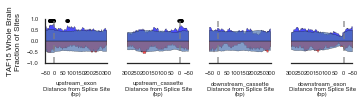

In [108]:
usable_splicing_datasets = [('taf15', 'whole brain')]
num_cols = 4
num_rows = len(usable_splicing_datasets)

with dataviz.Figure(os.path.join(img_dir, "distributions_around_alt_cassete_profile_taf15_only.svg"), figsize=(num_cols * 1.3,num_rows * 1.5)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    for y, col in enumerate(usable_splicing_datasets):
        rbp = col[0]
        if rbp not in coverage:
            continue
        rbp_of_interest = event_matrix[col] 
        activated = rbp_of_interest[rbp_of_interest > 0]
        repressed = rbp_of_interest[rbp_of_interest < 0]
        unchanged = rbp_of_interest[rbp_of_interest == 0]

        activated_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[activated.index].dropna()))
        repressed_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[repressed.index].dropna()))
        unchanged_tools = get_mapping_tools(create_array_exon_overlap_tool(alt_cassette_event_locations.ix[unchanged.index].dropna()))

        for x, (region, x_loc) in enumerate(plotting_order.items()):
            ax = fig.add_subplot(gs[y,x])
            activated_df = density_to_df(get_densities(activated_tools[region], coverage[rbp]))
            activated_plotter = (activated_df > 0).sum() / activated_df.count()

            repressed_df = density_to_df(get_densities(repressed_tools[region], coverage[rbp]))
            repressed_plotter = (repressed_df > 0).sum() / repressed_df.count()

            unchanged_df = density_to_df(get_densities(unchanged_tools[region], coverage[rbp]))
            unchanged_plotter = (unchanged_df > 0).sum() / unchanged_df.count()

            ax.vlines(0, -1, 1, linestyles="dashed", alpha=.7, color=".5")
            ax.fill_between(x_loc, 0, activated_plotter, alpha=.7, label="Included", facecolor="blue")
            ax.fill_between(x_loc, 0, repressed_plotter * -1, alpha=.7, label="Excluded", facecolor="red")

            ax.fill_between(x_loc, 0, unchanged_plotter, alpha=.7, label="Unchanging")
            ax.fill_between(x_loc, 0, unchanged_plotter * -1, alpha=.7, label="Unchanging")

            significant_activated = get_significant_sites(activated_df, unchanged_df)[0]
            significant_repressed = get_significant_sites(repressed_df, unchanged_df)[0]
            ax.scatter(x_loc[significant_activated], 
                       [.9] * len(x_loc[significant_activated]),
                       color='black', s=10)
            ax.scatter(x_loc[significant_repressed], 
                       [-.9] * len(x_loc[significant_repressed]),
                       color='black', s=10)
            ax.set_xlabel(region + "\nDistance from Splice Site\n(bp)", fontsize=6)
            ax.set_xlim((x_loc[0], x_loc[-1]))
            ax.set_ylim((-1,1))
            [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
            [tick.set_fontsize(6) for tick in ax.get_xticklabels()]

            if not ax.is_first_col():
                sns.despine(ax=ax, left=True)
                ax.set_yticklabels([])
            else: 
                sns.despine(ax=ax)
                ax.set_ylabel(" ".join([rbp_name_dict[col[0]], cell_type_dict[col[1]]]) + "\nFraction of Sites", fontsize=8)

            if ax.is_first_row() and ax.is_last_col():
                ax.legend(bbox_to_anchor=(1.5, 1))

In [109]:
activated_df = density_to_df(get_densities(activated_tools["upstream_exon"], coverage[rbp]))
activated_plotter = (activated_df > 0).sum() / activated_df.count()

repressed_df = density_to_df(get_densities(repressed_tools["upstream_exon"], coverage[rbp]))
repressed_plotter = (repressed_df > 0).sum() / repressed_df.count()

unchanged_df = density_to_df(get_densities(unchanged_tools["upstream_exon"], coverage[rbp]))
unchanged_plotter = (unchanged_df > 0).sum() / unchanged_df.count()
x
significant_activated = get_significant_sites(activated_df, unchanged_df)[0]
significant_repressed = get_significant_sites(repressed_df, unchanged_df)[0]
        
cur_alt_cassette_events = alt_cassette_events.ix[col]
bound_alt_cassette_events = cur_alt_cassette_events.ix[activated_df[(activated_df[significant_activated[:5]] > 0).apply(any, axis=1)].index]
bound_alt_cassette_events.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/splicing_event_locations/{}_{}_included_alt_cassette_events.csv".format("_".join(col), region))            

Conclusions
--
1. There appear to be position specific effects
2. Some of these effects go away when depth of coverage is normalized out
3. Need some way to test if a region is different than background given variance, t-test maybe?  

#Get TAF15 KD splicing events bound by TAF15 in mouse whole brain

In [110]:
activated_df = density_to_df(get_densities(activated_tools["upstream_exon"], coverage[rbp]))
activated_plotter = (activated_df > 0).sum() / activated_df.count()

repressed_df = density_to_df(get_densities(repressed_tools["downstream_cassette"], coverage[rbp]))
repressed_plotter = (repressed_df > 0).sum() / repressed_df.count()

unchanged_df = density_to_df(get_densities(unchanged_tools["downstream_cassette"], coverage[rbp]))
unchanged_plotter = (unchanged_df > 0).sum() / unchanged_df.count()

significant_activated = get_significant_sites(activated_df, unchanged_df)[0]
significant_repressed = get_significant_sites(repressed_df, unchanged_df)[0]


In [111]:
taf15_whole_brain_alt_cassette = alt_cassette_events.ix['taf15', 'whole brain']
bound_alt_cassette_events = taf15_whole_brain_alt_cassette.ix[activated_df[(activated_df[significant_activated[:-6]] > 0).apply(any, axis=1)].index]

alt_cassette_exons[alt_cassette_exons.event_id.isin(bound_alt_cassette_events.old_splice_annotation)].to_csv("/nas3/gpratt/Dropbox/TAF15/Data/SplicingAnalysis_array/splicing_event_locations/taf15_whole_brain_included_alt_cassette_events.csv", index=None)

#Notes on how to parse 

(if I want to re-parse stephs list of alt-cassette exons)
Is the file you want

Original code is here:
/nas3/shuelga/old_projects/TLS/jxnarray/get_event_exons.pl

File to parse is here:
/nas3/shuelga/projects/tdp43_eveline/ffmm9eventinfo_coords_allevents_seq.txt

spans_with_positions is the important column.

You want to parse the span, split em up by ;.  Then I'm not sure what the 14.16,16.16 stuff is, but I think those are the exons and spans, You want the span across the exon so make sure they are equal.  This won't always work, so build in some robustness into your parser.  

In [112]:
event_annotations = pd.read_table("/nas3/shuelga/projects/tdp43_eveline/ffmm9eventinfo_coords_allevents_seq.txt", index_col=0)
alt_cassette_annotations = event_annotations[event_annotations.notes2 == "alt_cassette"]

#Future Ideas

Test Hypothesis of compensatory mutations preventing observation of splicing events

At the location of TAF15 specific knockdown spice events does FUS / TDP43 also bind?

How many unique gene expression changes are bound by other RBPs in clip